In [7]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time
import math

* If no wavelet is passed, mWDN uses "Daubechies 4 Wavelet" described in the paper

* !!! under the hood, Residual Classification Flow (RCF) is used for Time Series Classification !!!

* !!! Plus models are meant for forecasting, so default InceptionTimePlus arch should be changed to InceptionTime for TSC

* Level=2 => 2 classifiers used

* MLP, FCN, ResNet were tested in the paper as RCF classifiers

* TSAI sets InceptionTime as the default RCF classifier

* other classifiers which could probably be used: XResNet1d, ResCNN, OmniScaleCNN, XCM, TCN (haven't made it run as intended yet), XceptionTime (haven't made it run as intended yet)

* as for now, classifiers passed to mWDN will have their default hyperparameters set (can be passed via **kwargs)

In [4]:
%run ../../shared_functions.py
%run ../../my_shared_functions.py

In [5]:
DIR_INPUT = '../../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 375 ms
Wall time: 385 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [8]:
base_archs = {
    'InceptionTime' : tsai.all.InceptionTime,
    'MLP' : tsai.all.MLP, # RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x60 and 75x500)
    'FCN' : tsai.all.FCN, # ~13sec 1 epoch
    'ResNet' : tsai.all.ResNet, #~27sec 1 epoch
    # 'xresnet1d50_deeper' : tsai.all.xresnet1d50_deeper, - first check XResNet test results
    'ResCNN' : tsai.all.ResCNN, #~20sec 1 epoch
    'OmniScaleCNN' : tsai.all.OmniScaleCNN, # ~3min 1 epoch
    'XCM' : tsai.all.XCM #~19sec 1 epoch
    }

#### Default (changed to Level=2 instead of Level=3, otherwise error is thrown)

In [9]:
BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7

delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5

In [10]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cuda


In [11]:
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])

#### MLP test

In [13]:
tsai.all.MLP(15, 1, 5)

MLP(
  (flatten): Reshape(bs, -1)
  (mlp): ModuleList(
    (0): LinBnDrop(
      (0): Dropout(p=0.1, inplace=False)
      (1): Linear(in_features=75, out_features=500, bias=True)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): ReLU(inplace=True)
    )
  )
  (head): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=500, out_features=1, bias=True)
    )
  )
)

KeyboardInterrupt: 

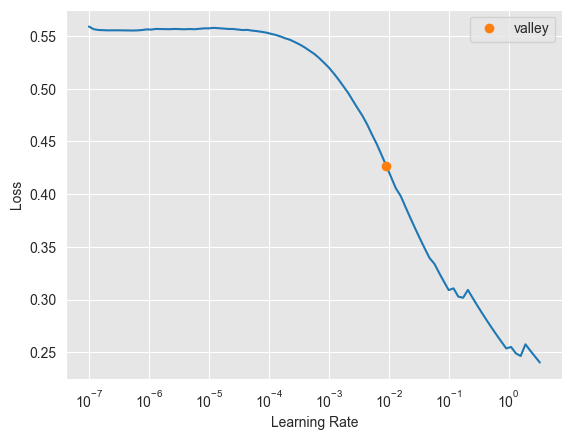

In [26]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, num_workers=0, drop_last=False, device=DEVICE)
model = tsai.all.mWDN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    levels=2,
    base_arch=tsai.all.XCM
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    cbs=[EarlyStoppingCallback(
            patience=2
        )])

lr = learn.lr_find().valley

start_time=time.time()
learn.fit_one_cycle(100, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

#### XResNet test

KeyboardInterrupt: 

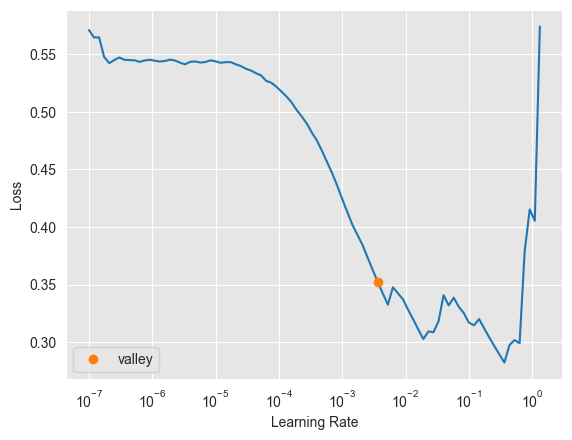

In [17]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, num_workers=0, drop_last=False, device=DEVICE)
model = tsai.all.mWDN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    levels=2,
    base_arch=tsai.all.xresnet1d50_deeper
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='mWDN',
    cbs=[EarlyStoppingCallback(
            patience=2
        )])

lr = learn.lr_find().valley

start_time=time.time()
learn.fit_one_cycle(100, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

#### Fit 1 cycle 

In [8]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'train test split',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    levels=2,
    wavelet=None,
    base_arch='InceptionTime',
    early_stopping=True,
    early_stopping_patience=2,
    max_epochs=100,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['mwdn', 'tsai', 'imbalance-not-considered'])
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin


In [9]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.mWDN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    levels=2,
    wavelet=config.wavelet,
    base_arch=base_archs[config.base_arch]
    )

In [10]:
criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='mWDN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        EarlyStoppingCallback(
            patience=config.early_stopping_patience
        ),
        SaveModelCallback(
            fname='mwdn_fit_one_cycle'
        )])

wandb: Network error resolved after 0:00:39.967094, resuming normal operation.


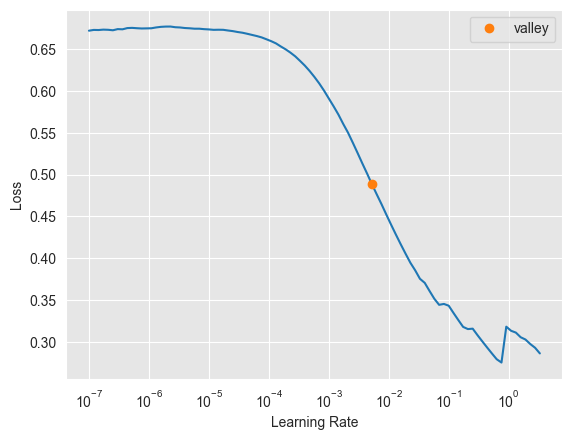

In [11]:
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

In [12]:
start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


Better model found at epoch 0 with valid_loss value: 0.022704986855387688.
Better model found at epoch 1 with valid_loss value: 0.019963420927524567.
Better model found at epoch 2 with valid_loss value: 0.0198792964220047.
No improvement since epoch 2: early stopping


In [13]:
start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

AUC ROC  Average precision  F1 score  Card Precision@100
0    0.891              0.657     0.605               0.303

In [14]:
wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### Sweeps

In [27]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
delta_valid = delta_test

n_folds=4

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)
delta_assessment = delta_valid

In [28]:
SEED = 42
seed_everything(SEED)

prequential_split = []
        
for fold in range(n_folds):
    start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
    
    (train_df, test_df)=get_train_test_set(transactions_df,
                                            start_date_training=start_date_training_fold,
                                            delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
    prequential_split.append((train_df, test_df))

In [29]:
SEQ_LEN = 5
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


#### Fit 1 cycle

In [30]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'goal': 'minimize',
        'name': 'val_loss'
        },
    'parameters': {
        'one_cycle_policy' : {
            'value' : True
        },
        'batch_size': {
            'values' : [64, 128, 256]
        },
        'max_epochs': {
            'values': [2, 3, 4, 5, 6, 7, 8, 9, 10]
        },
        'num_workers': {
            'value' : 0
        },
        'seed': {
            'value' : 42
        },
        'levels': { 
            'value' : 2
        },
        'wavelet': {
            'value' : None
        },
        'base_arch': {
            # MLP does not work
            # 1 epoch of OmniScaleCNN takes ~3min (on one split)
            'values' : ['InceptionTime', 'FCN', 'ResNet', 'ResCNN', 'XCM']
        }
    }
 }

In [31]:
sweep_id = wandb.sweep(sweep_config, project="mgr-anomaly-tsxai-project")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: f61pt6po
Sweep URL: https://wandb.ai/mgr-anomaly-tsxai/mgr-anomaly-tsxai-project/sweeps/f61pt6po


In [32]:
def train(config=None):
    with wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['mwdn', 'tsai', 'imbalance-not-considered', 'sweeps']):
        config = wandb.config
        training_execution_times = []
        prediction_execution_times = []
        aucs = []
        average_precisions = []
        f1_scores = []
        card_precisions = []
        for i in range(n_folds):
            train_df = prequential_split[i][0]
            valid_df = prequential_split[i][1]
            (train_df, valid_df)=scaleData(train_df, valid_df,input_features)
            x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
            x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
            X, y, tsai_splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])
            dsets = tsai.all.TSDatasets(X, y, splits=tsai_splits, inplace=True)
            dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, device=DEVICE, drop_last=False)
            
            model = tsai.all.mWDN(
                c_in=dls.vars, 
                c_out=dls.c,
                seq_len=SEQ_LEN,
                levels=config.levels,
                wavelet=config.wavelet,
                base_arch=base_archs[config.base_arch]
                )
            
            criterion = tsai.all.BCEWithLogitsLossFlat()
            learn = tsai.all.ts_learner(
                dls,
                model,
                loss_func=criterion,
                opt_func=tsai.all.Adam,
                device=DEVICE,
                metrics=[],
                model_dir='mWDN',
                cbs=[
                    WandbCallback(
                        log=None,
                        log_model=False,
                        seed=config.seed)])

            valley = learn.lr_find().valley

            start_time=time.time()
            learn.fit_one_cycle(config.max_epochs, valley)
            training_execution_times.append(time.time()-start_time)

            start_time=time.time()
            valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
            prediction_execution_time=time.time()-start_time
            predictions_df = valid_df
            predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
                
            performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
            aucs.append(performance_df.loc[0,'AUC ROC'])
            average_precisions.append(performance_df.loc[0,'Average precision'])
            f1_scores.append(performance_df.loc[0,'F1 score'])
            card_precisions.append(performance_df.loc[0,'Card Precision@100'])

        wandb.log({'Training execution time': np.sum(training_execution_times) / n_folds})
        wandb.log({'Prediction execution time': np.sum(prediction_execution_times) / n_folds})
        wandb.log({'AUC ROC': np.sum(aucs) / n_folds})
        wandb.log({'Average precision': np.sum(average_precisions) / n_folds})
        wandb.log({'F1 score': np.sum(f1_scores) / n_folds})
        wandb.log({'Card Precision@100': np.sum(card_precisions) / n_folds})

wandb: Agent Starting Run: 2e1ydpg6 with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: rorrqa9s with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: cvzzp6sq with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0b7mnvl2 with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vzsomkwo with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: d1wcbq87 with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 9
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ij9uglw4 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22ok1u8g with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6lvs2viu with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: c4ve6yth with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kcdh1a0g with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: o9iw2e8l with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: da82nc98 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 36q807t0 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: sbwv31we with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: arxuxllp with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 31huv1lg with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: jip59tdh with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 9
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: uoh51v57 with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3j9o4fh7 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 2u5zh7cn with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 9
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: rnnr15si with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: uc98pi6l with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 5ffmk70b with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6d3onpgt with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 1rzl84fm with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: aj4djgmw with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 9
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: f3ukqc74 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7noefd4b with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: nvk3vfnl with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgrqypi0 with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 2
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ro2x1zvu with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 76ghokvx with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 2
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 3n4q5nrt with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7kbiar21 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7h6v2zfz with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: d35nhizx with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ubattasx with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: fkbnhyaj with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5z3pvz41 with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: yo0gebtx with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: grnxbuv8 with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jqp8d14f with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ukaa8ugs with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 61zlkdyj with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 9
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: jc95heq1 with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 6ktccg3p with config:
wandb: 	base_arch: ResCNN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: at5ons4f with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7yyl1ikv with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 2
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: c0cpvm18 with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t0u1b360 with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 6faug1yi with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 64
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 0m9vio7b with config:
wandb: 	base_arch: FCN
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sgfrzy2h with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6zlm594 with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 0ocmtooy with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: kev4pqsu with config:
wandb: 	base_arch: ResNet
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: e9pm7sdq with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 9
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: tixlkr2s with config:
wandb: 	base_arch: InceptionTime
wandb: 	batch_size: 256
wandb: 	levels: 2
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u10odsev with config:
wandb: 	base_arch: XCM
wandb: 	batch_size: 128
wandb: 	levels: 2
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
wandb: 	wavelet: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


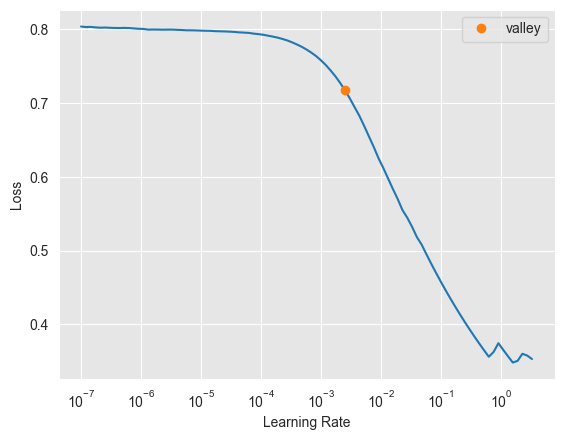

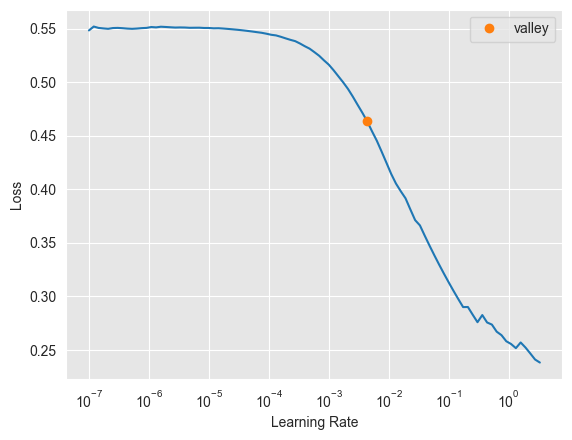

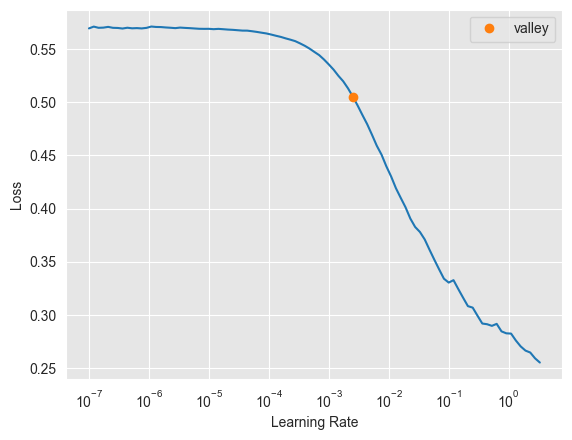

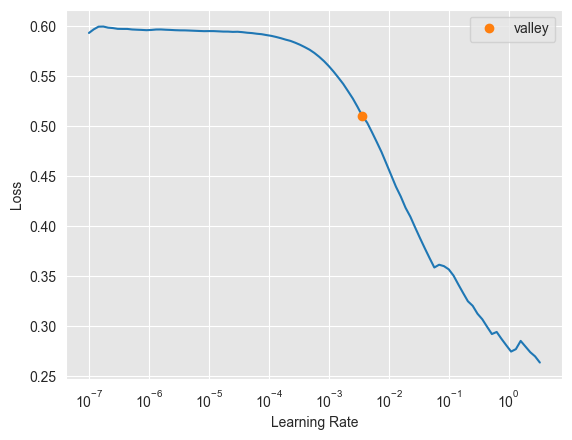

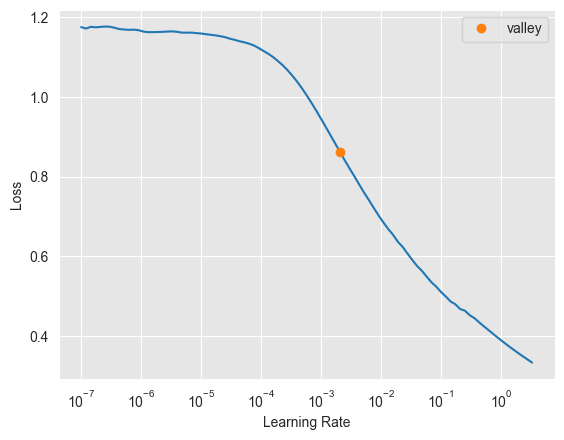

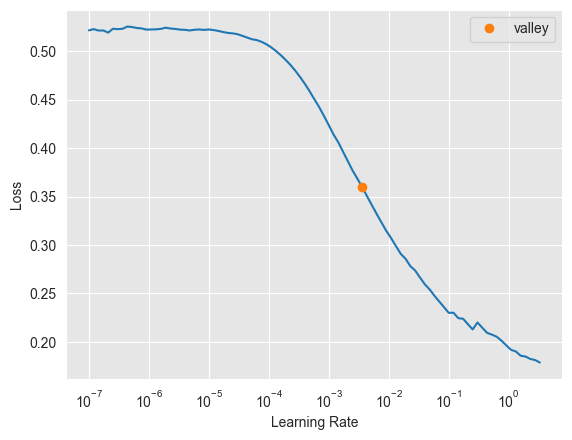

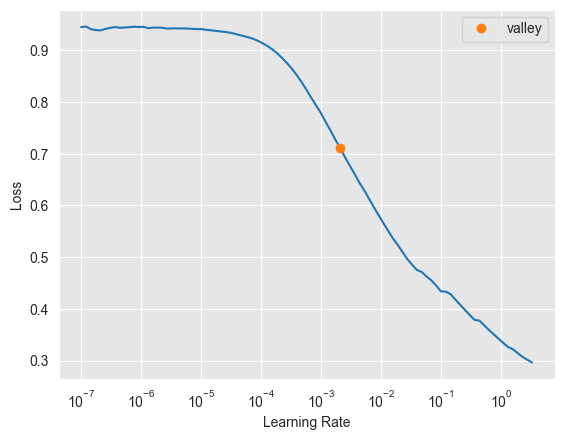

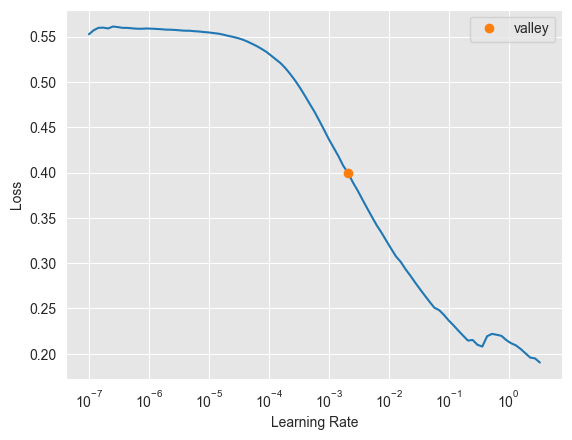

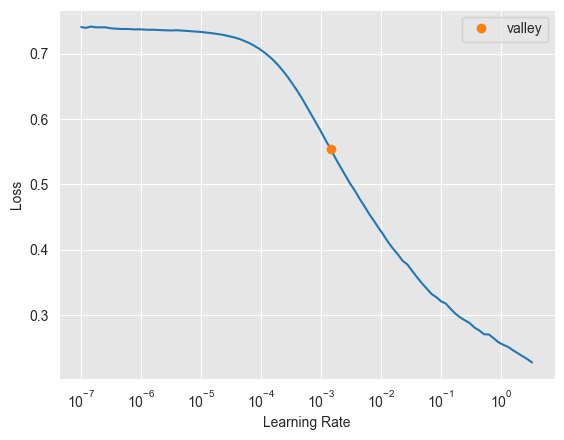

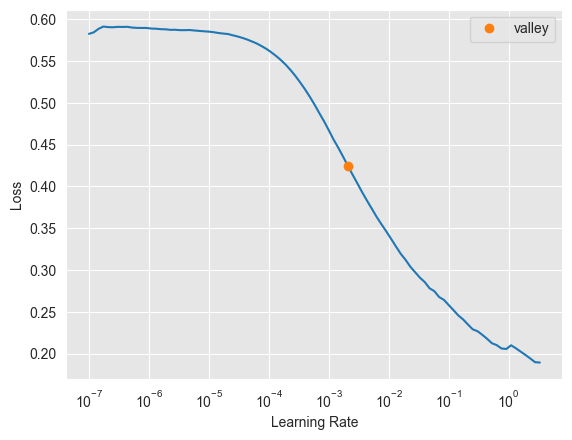

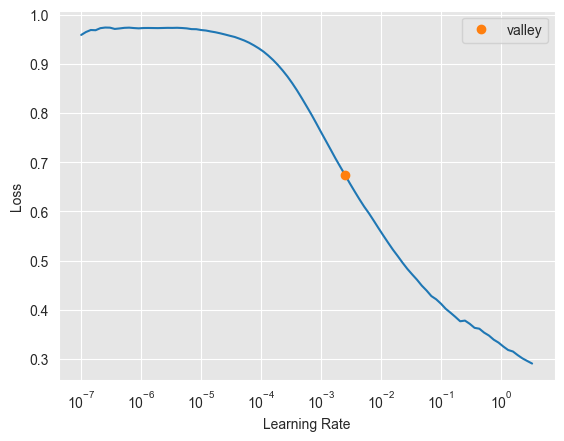

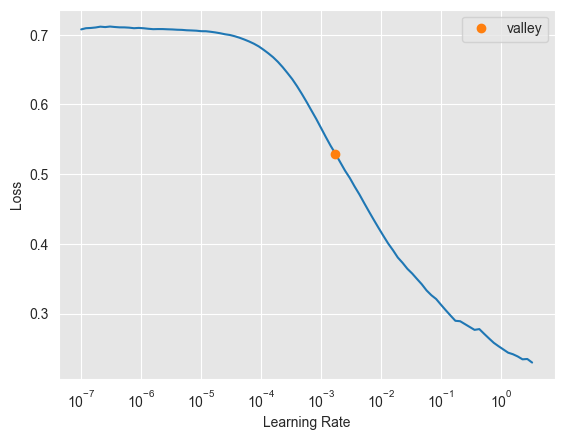

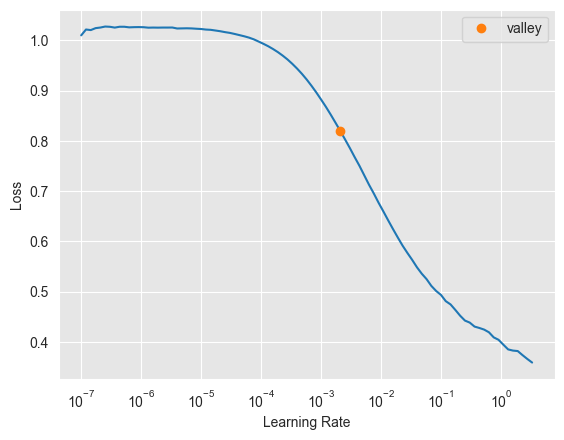

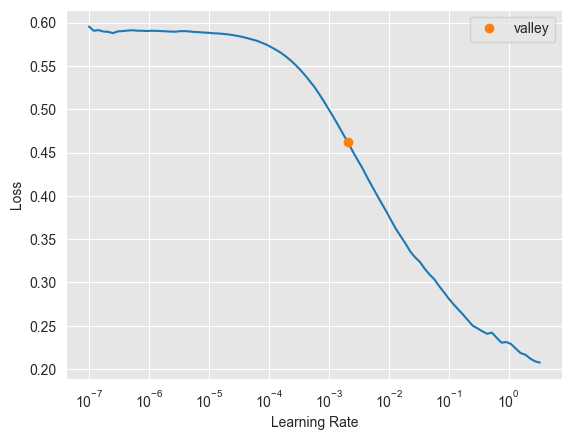

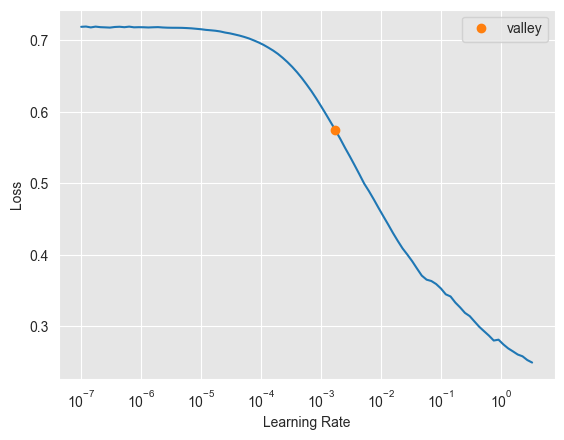

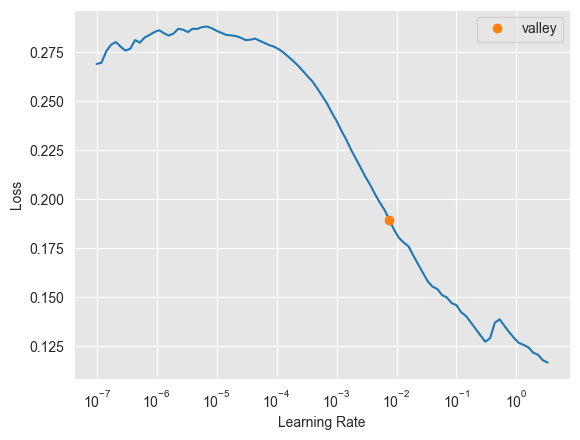

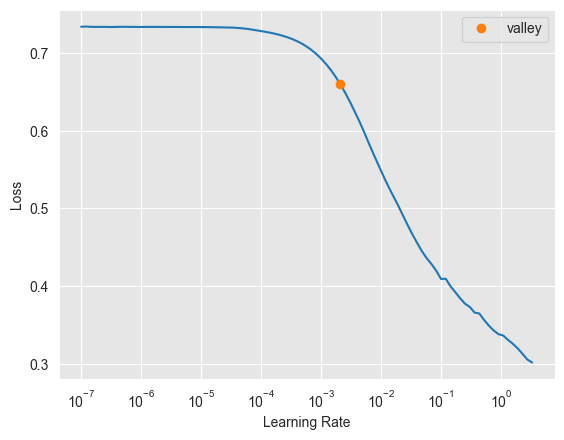

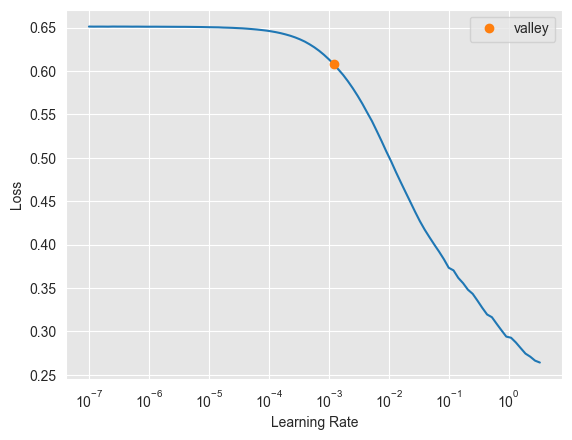

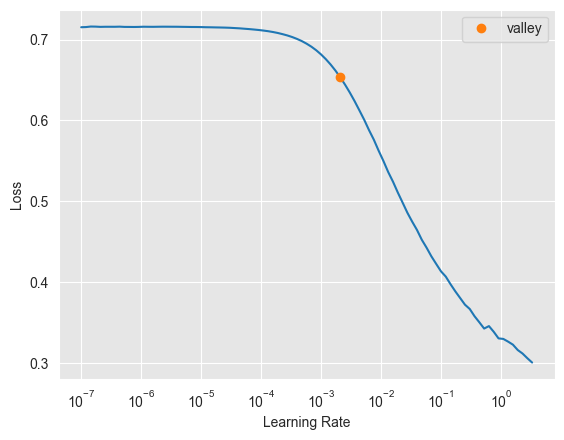

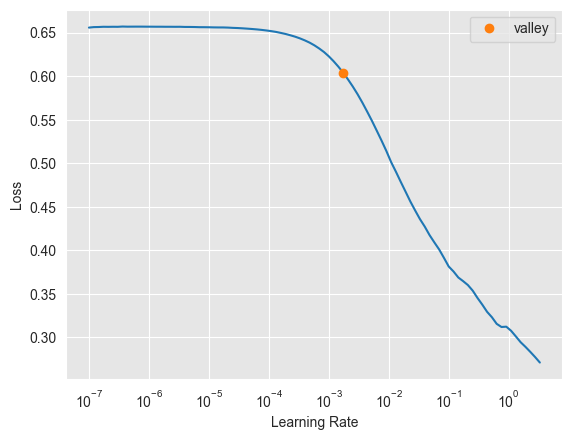

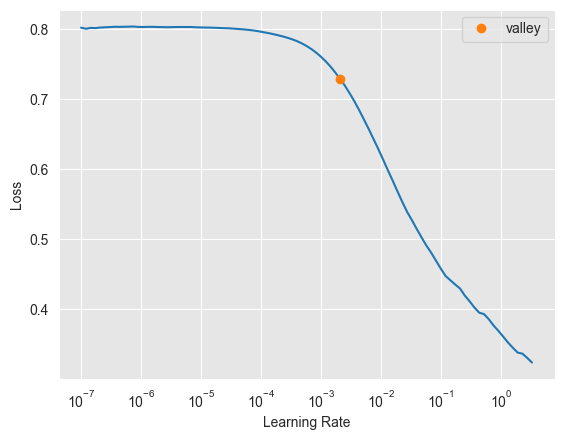

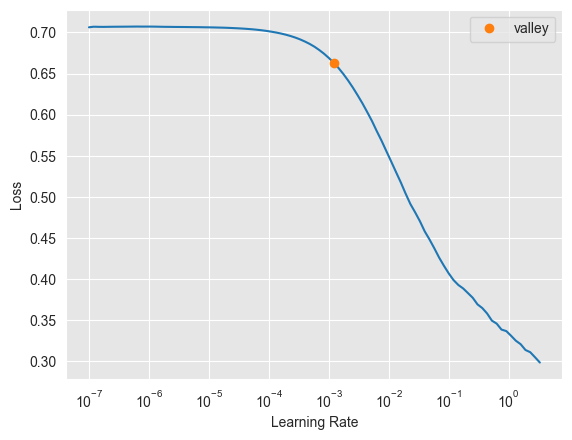

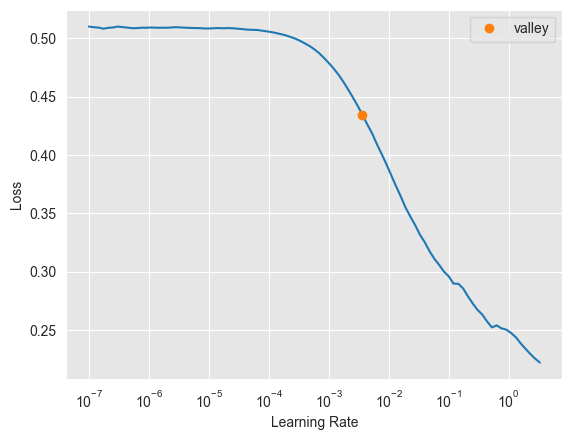

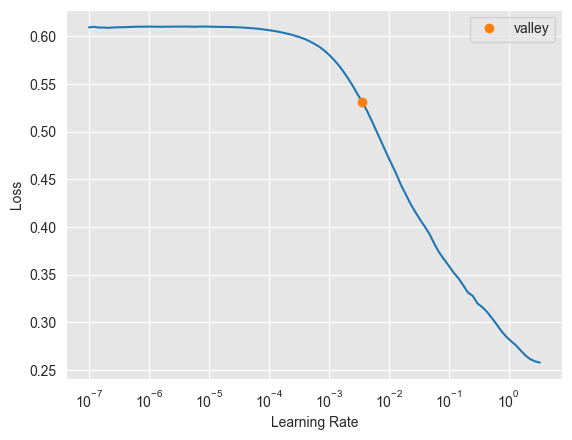

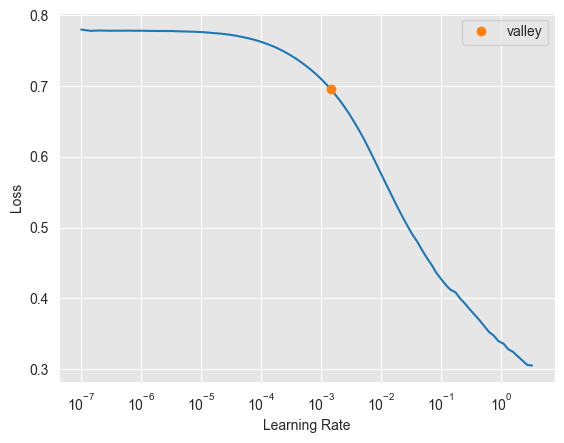

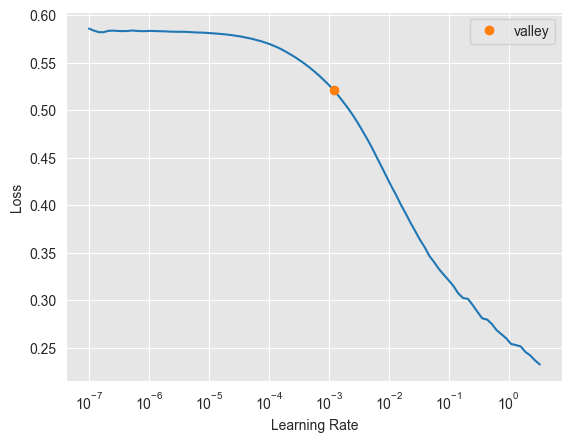

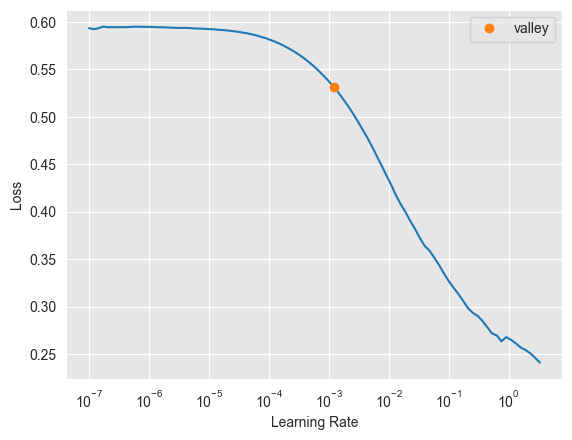

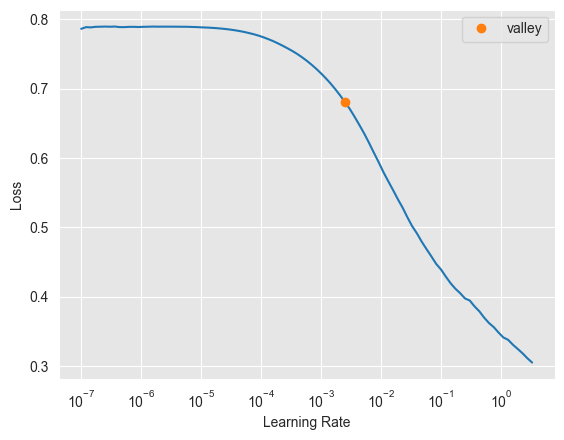

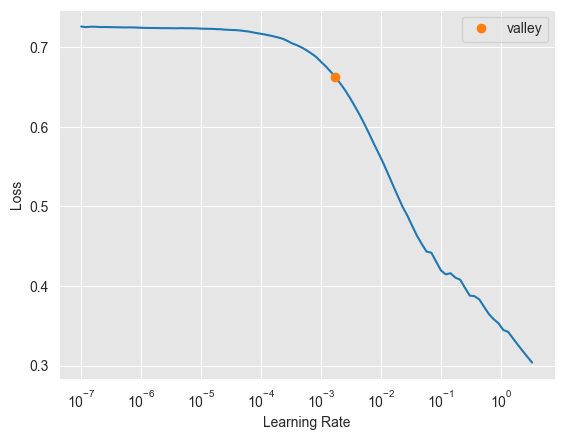

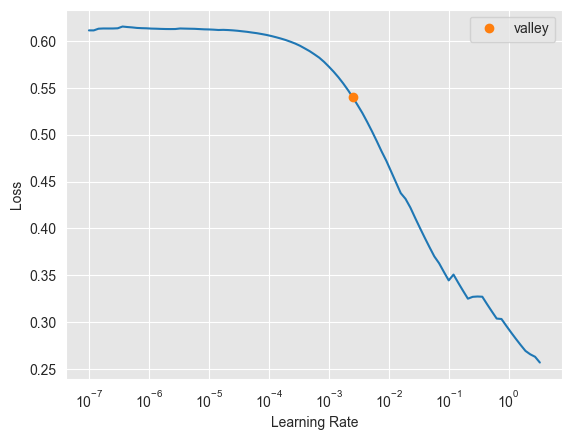

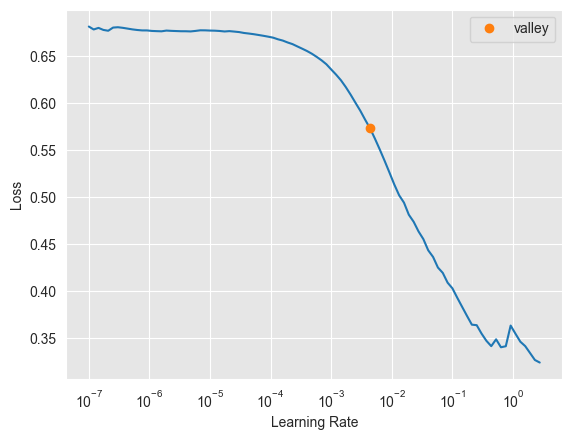

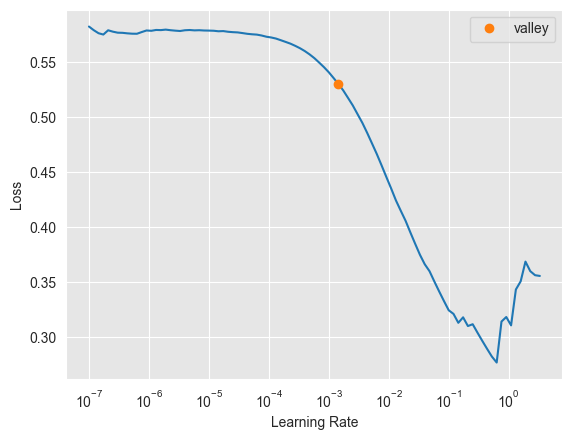

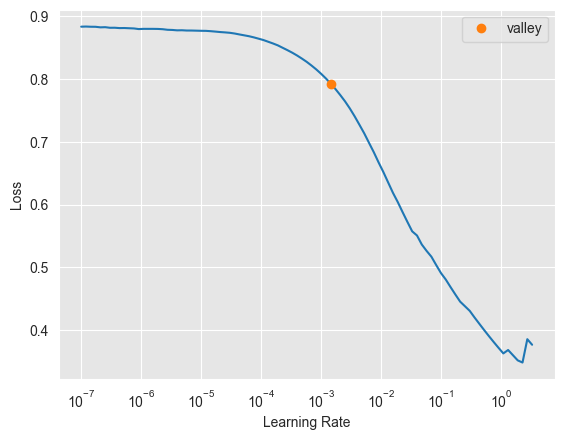

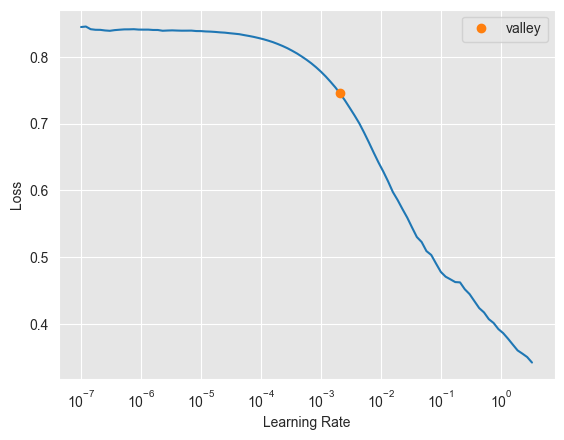

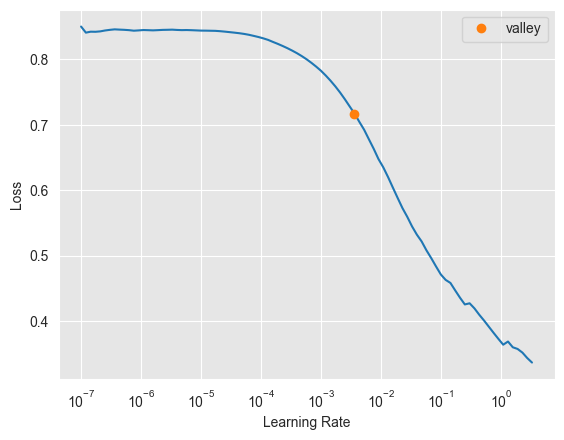

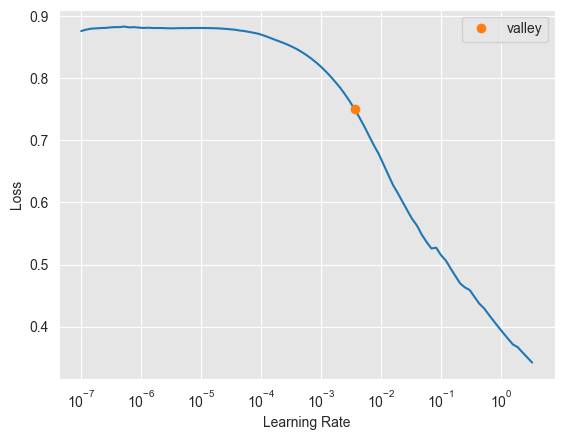

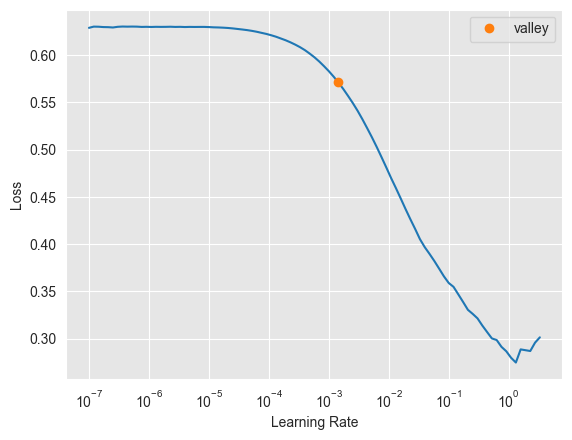

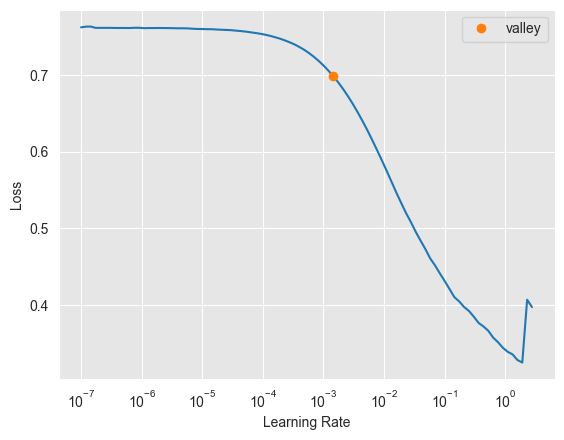

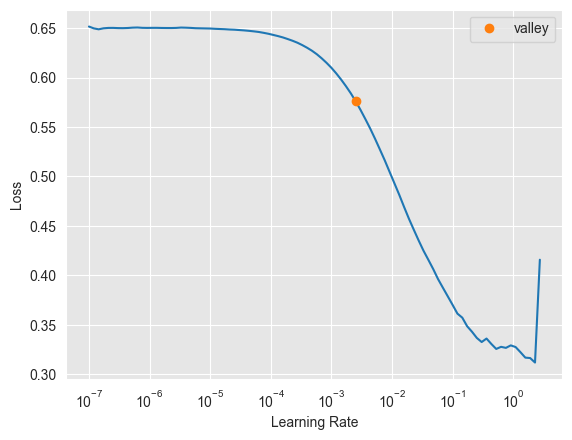

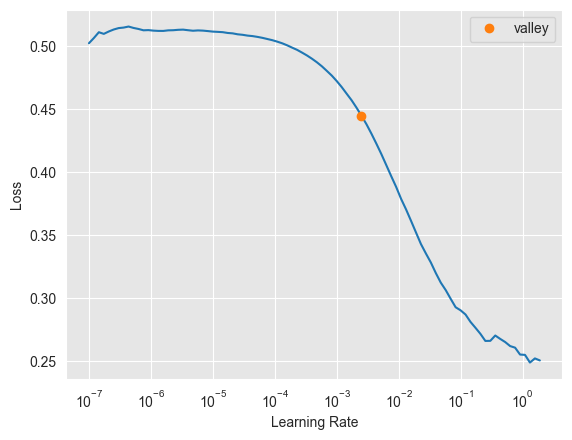

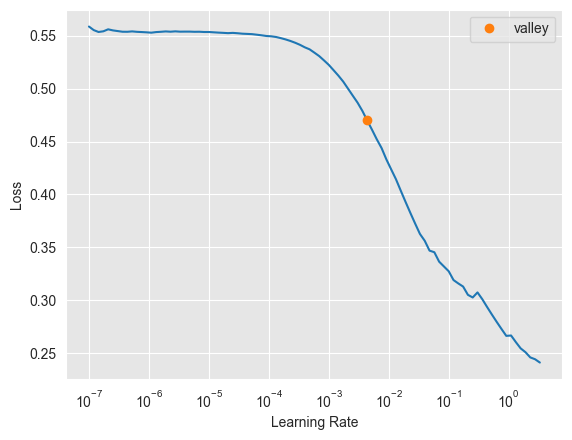

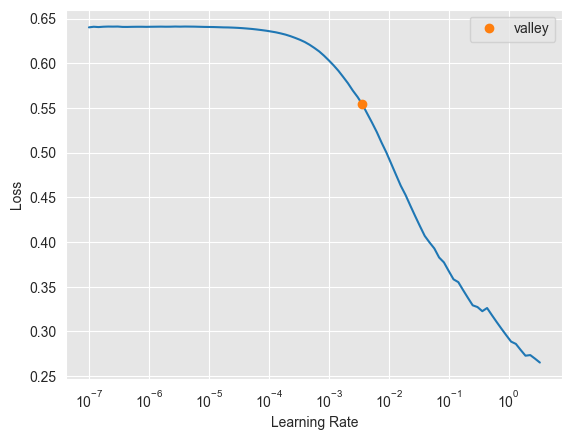

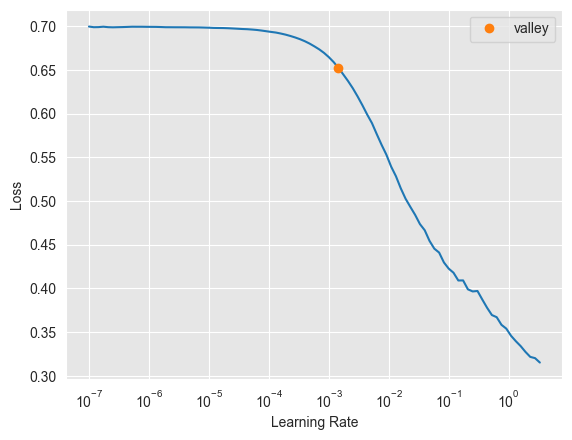

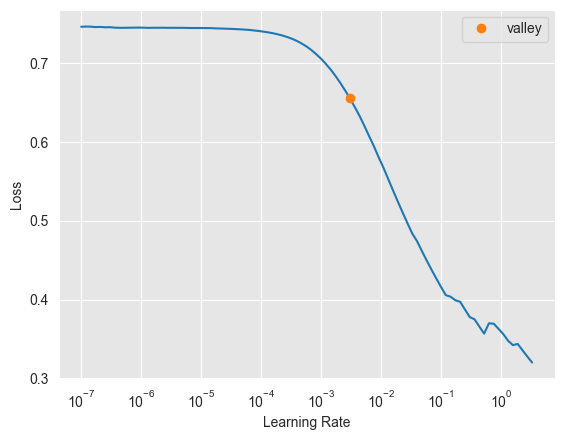

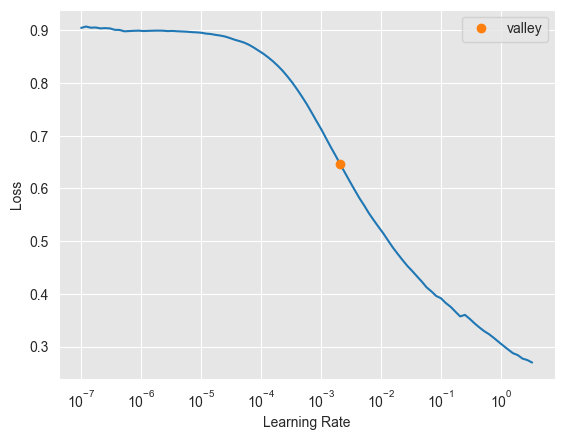

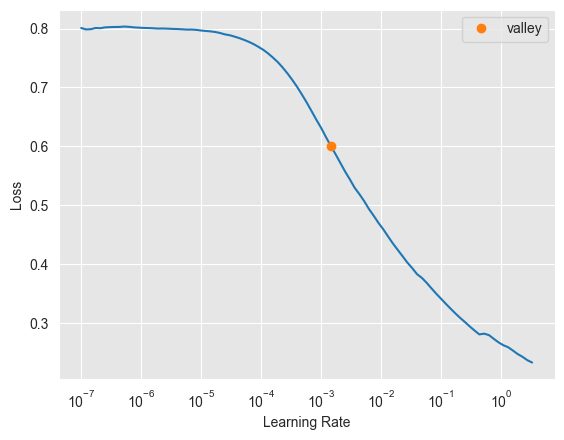

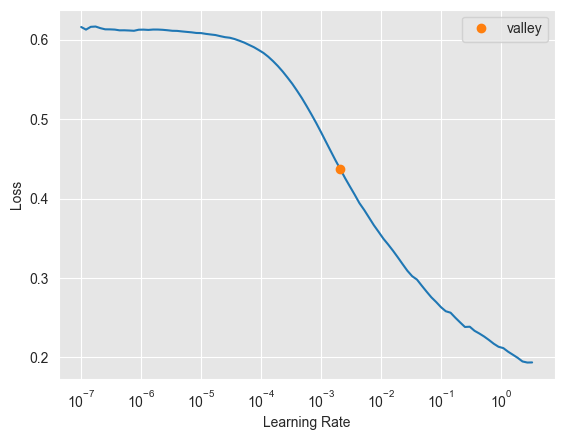

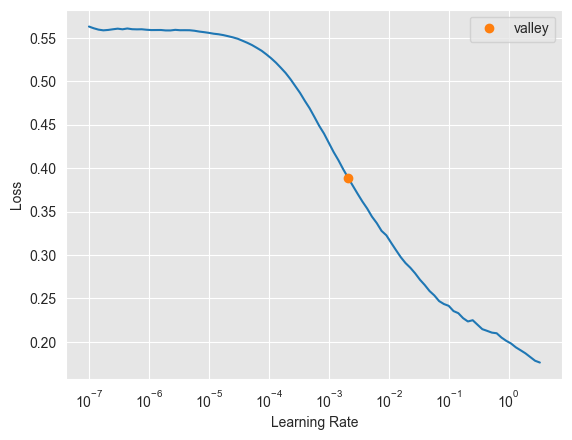

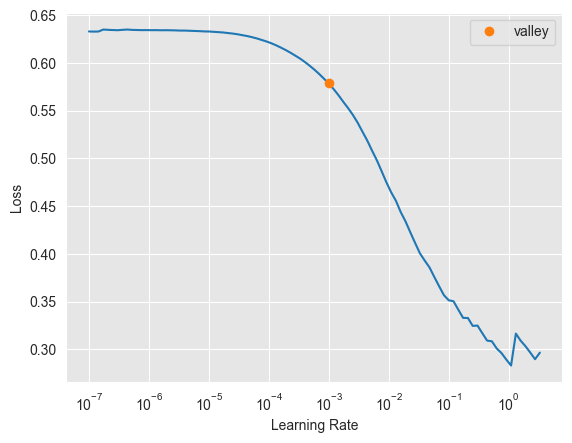

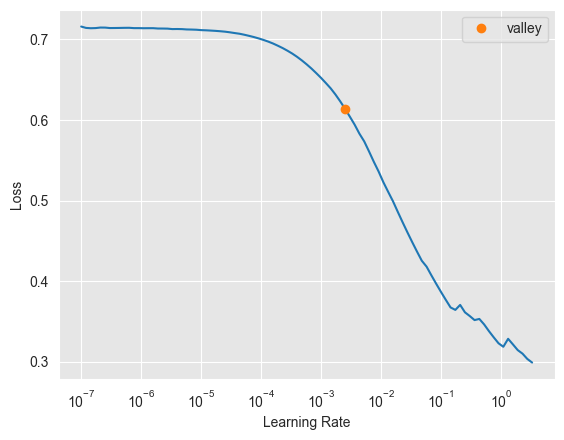

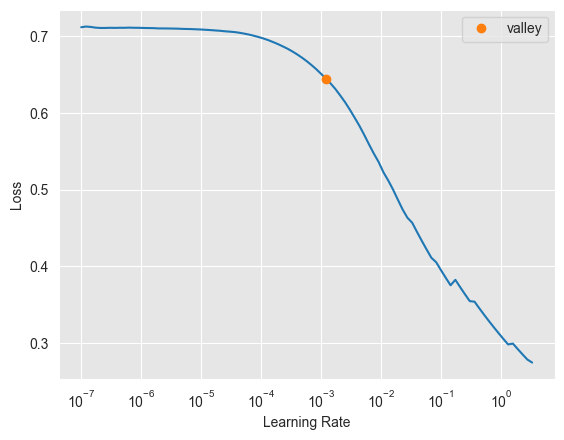

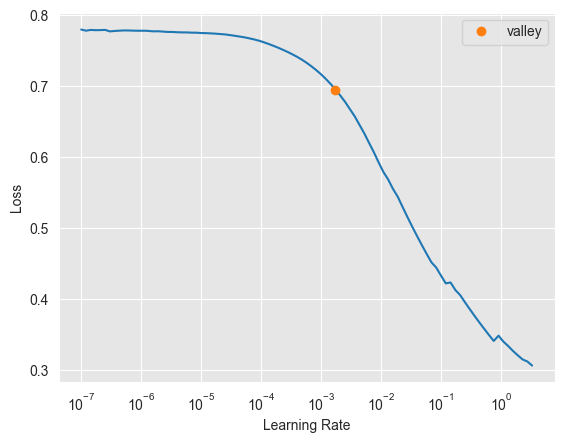

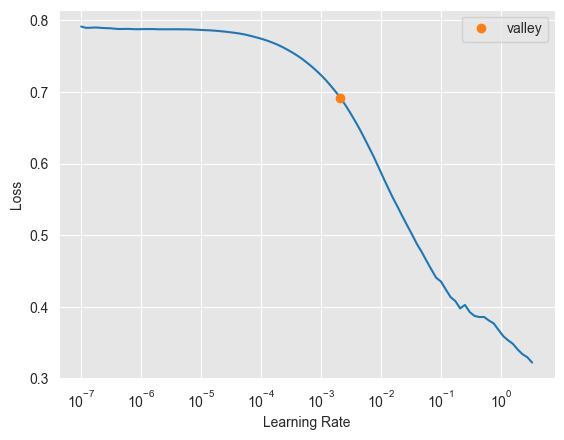

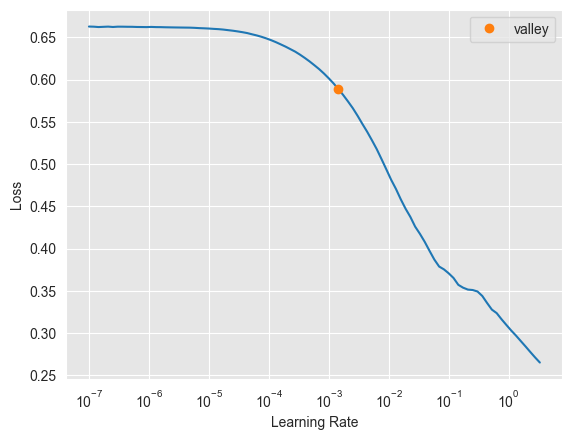

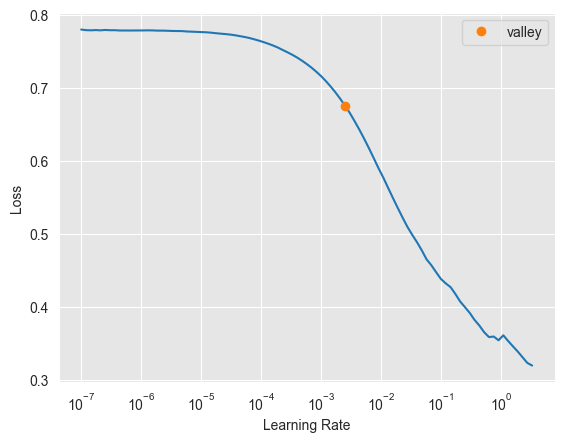

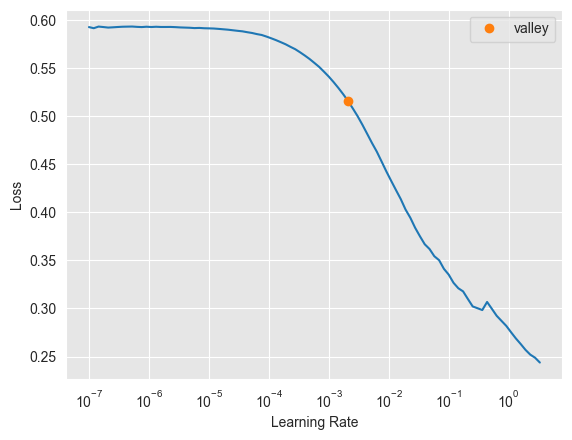

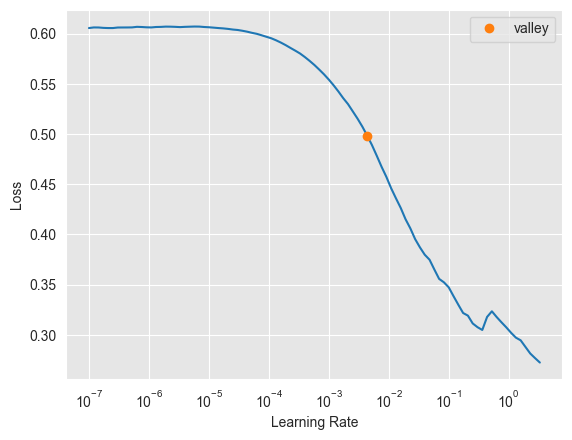

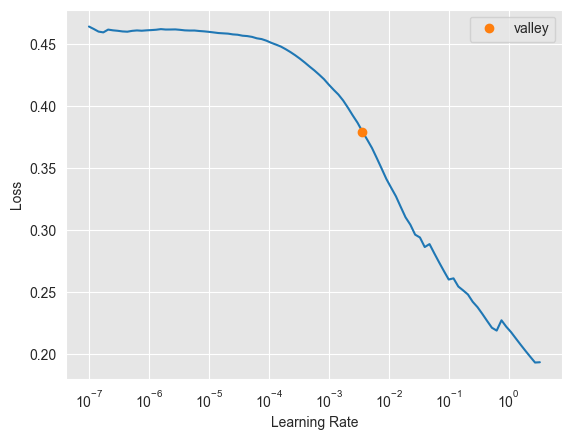

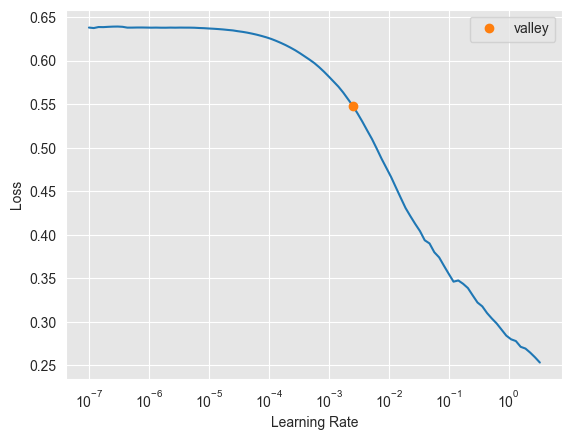

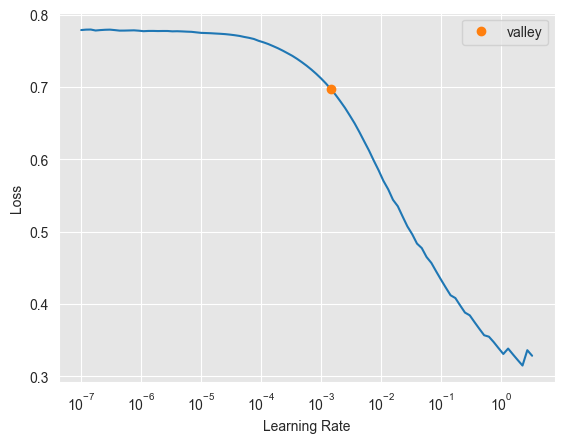

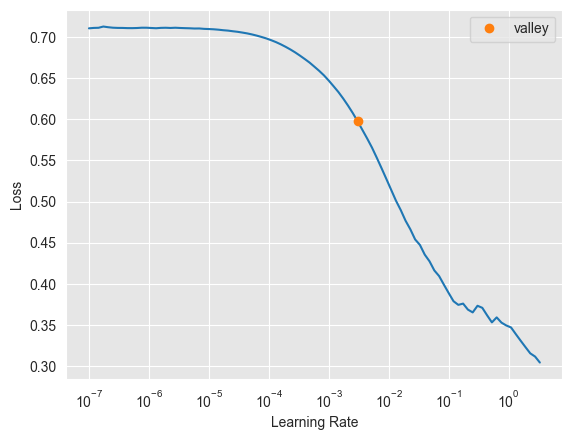

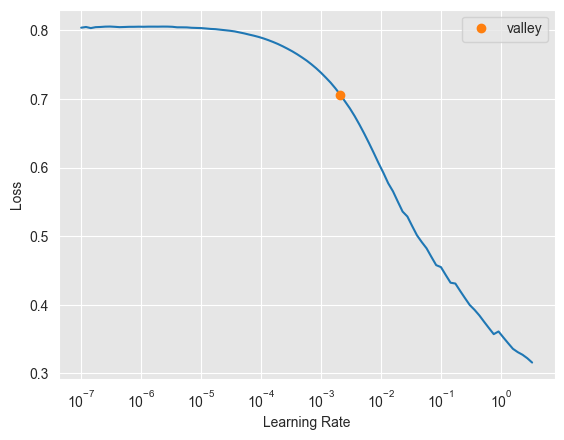

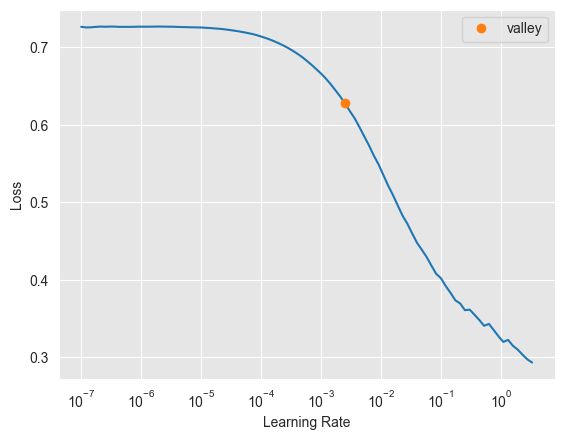

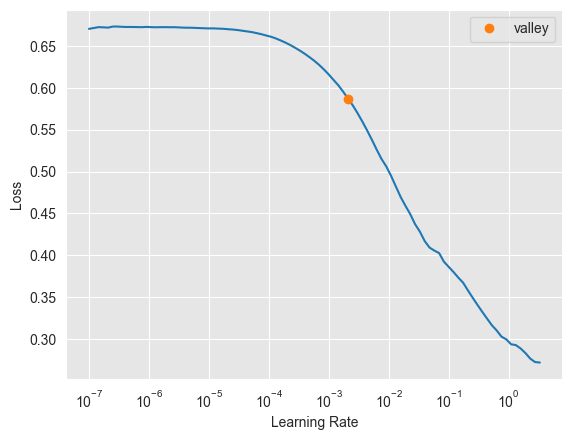

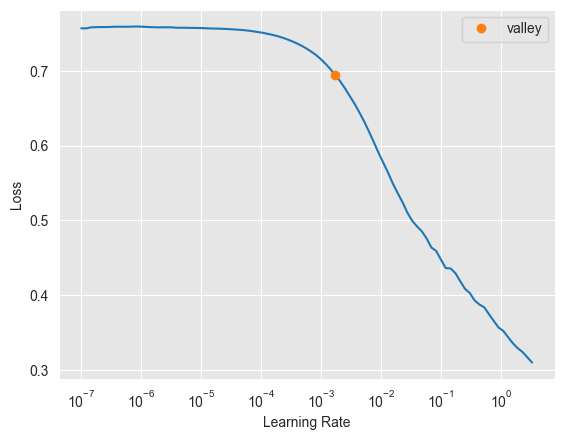

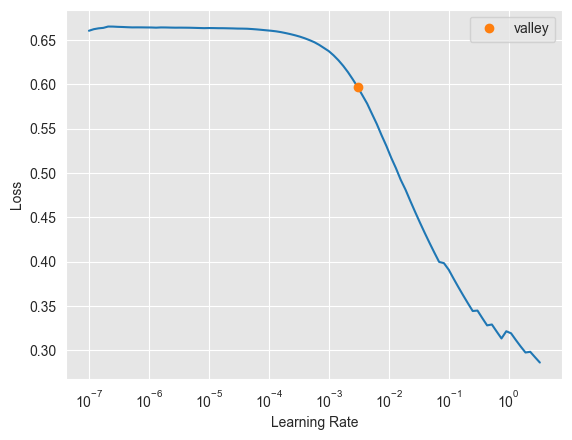

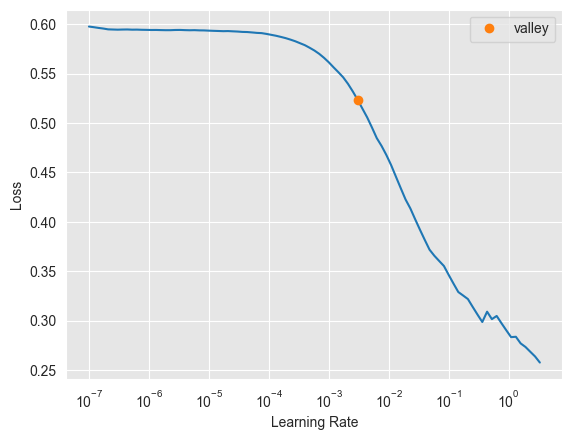

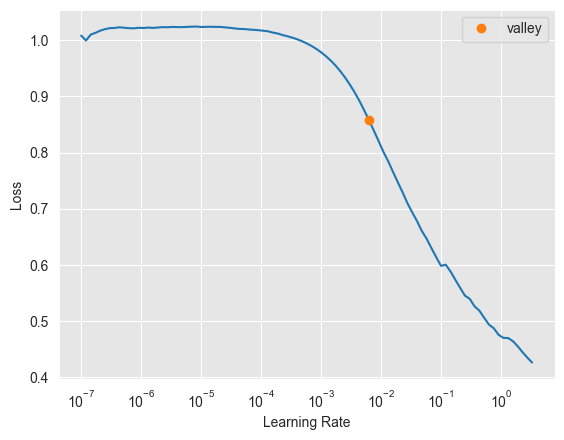

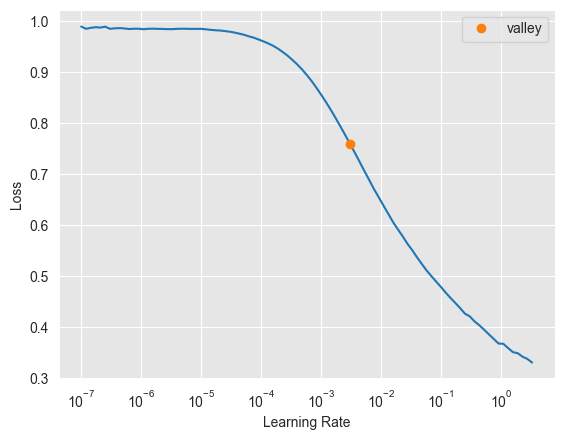

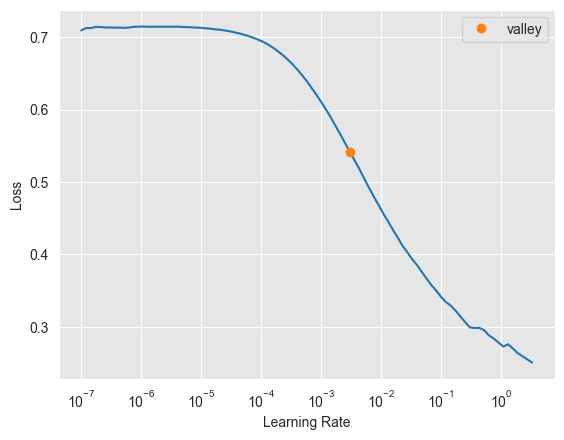

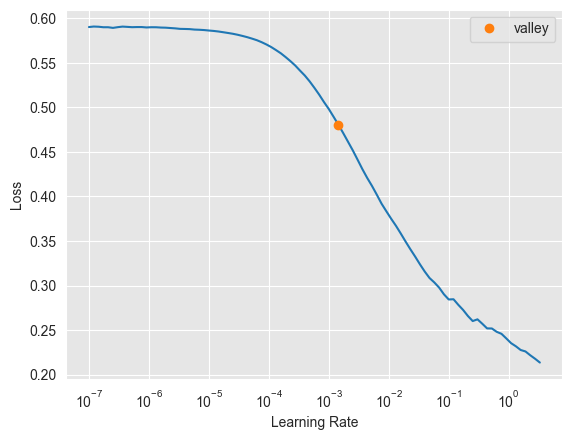

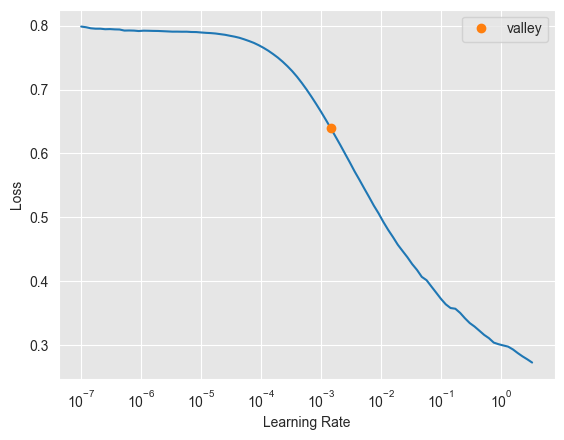

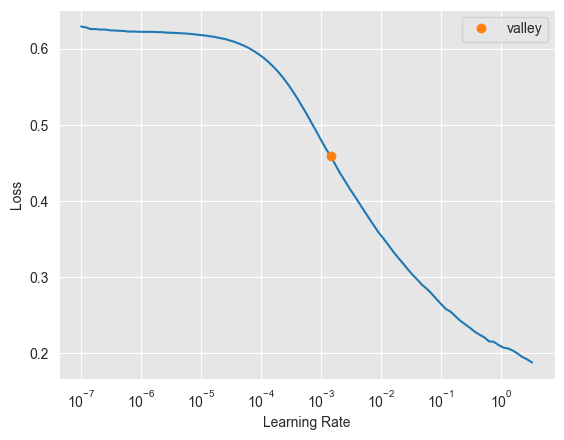

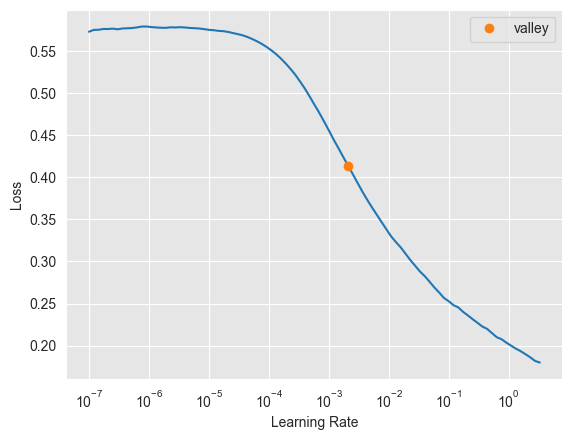

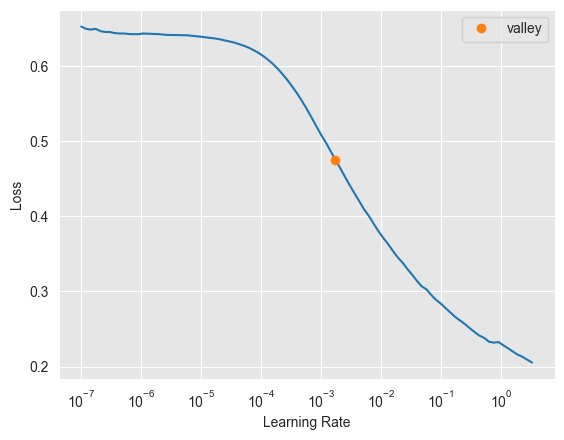

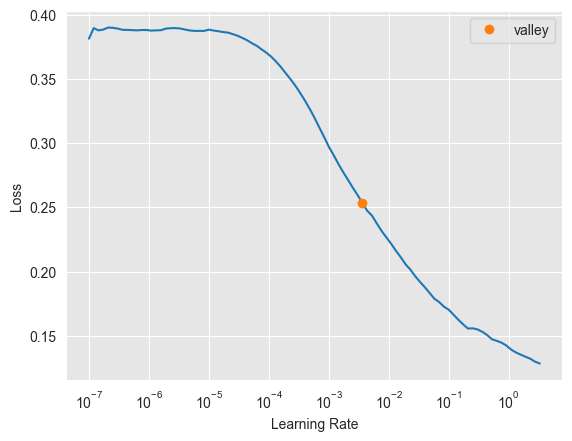

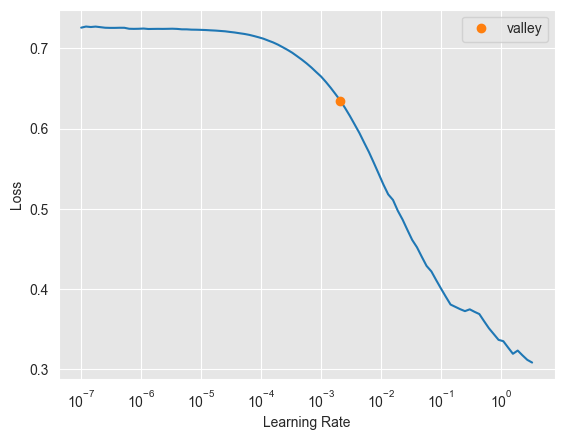

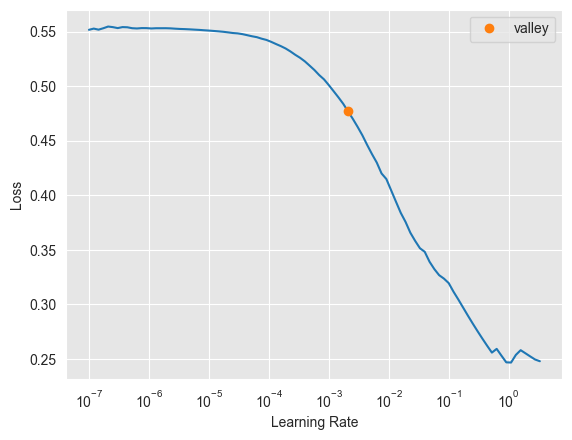

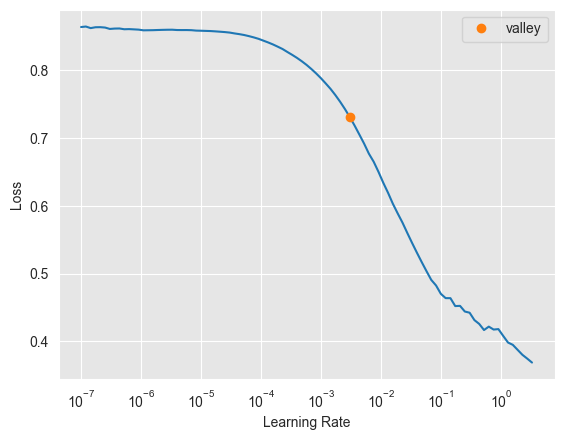

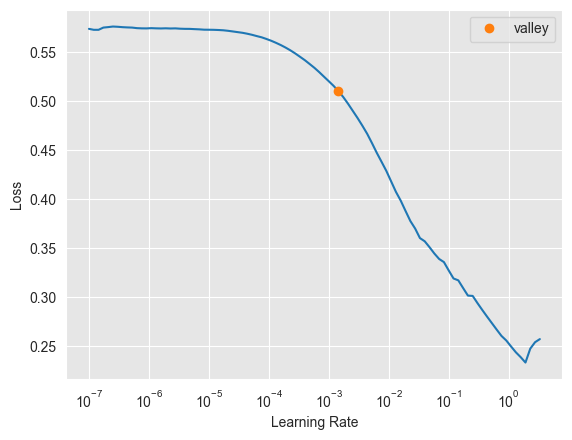

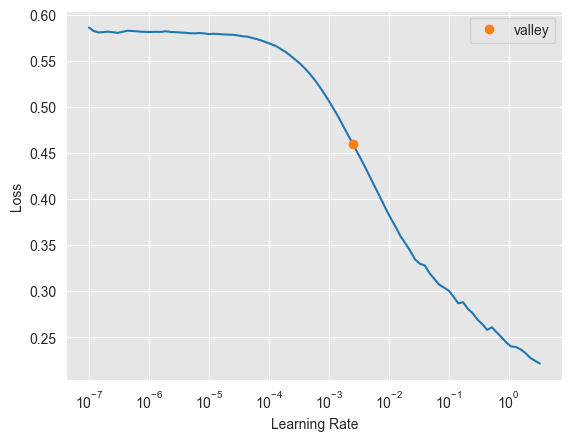

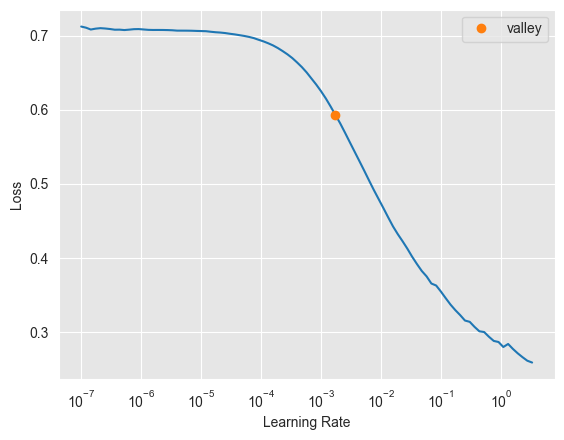

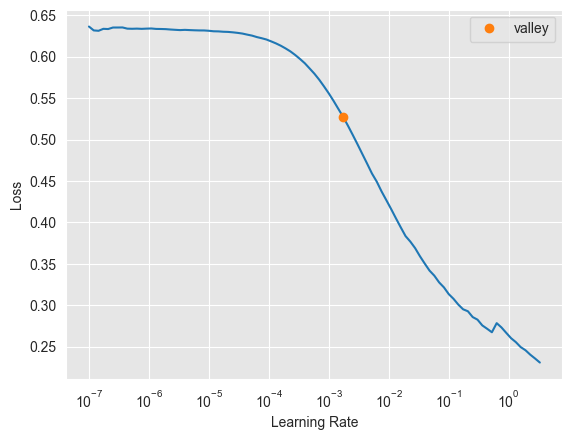

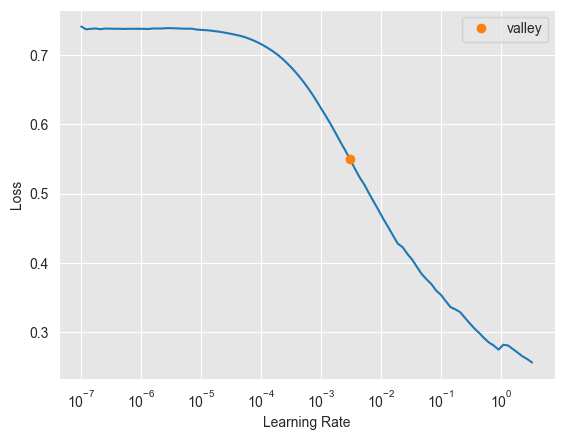

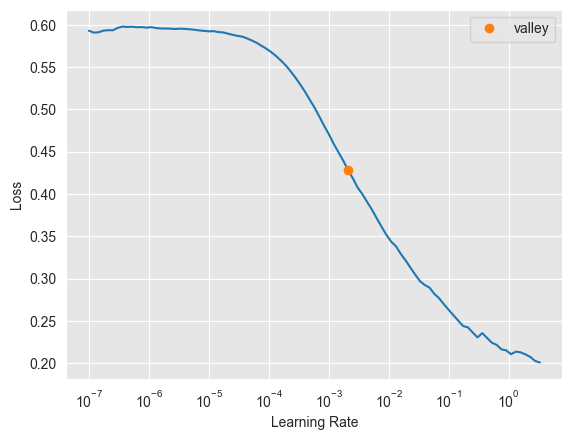

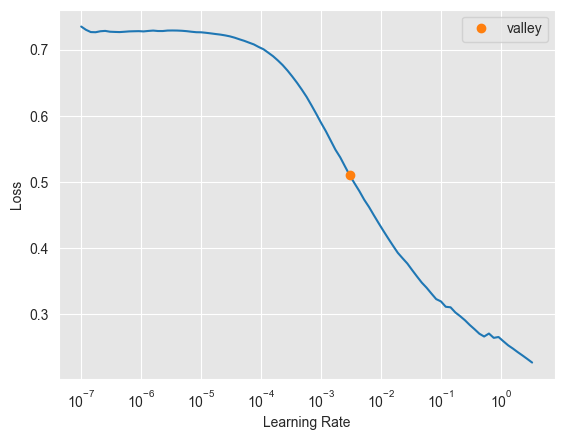

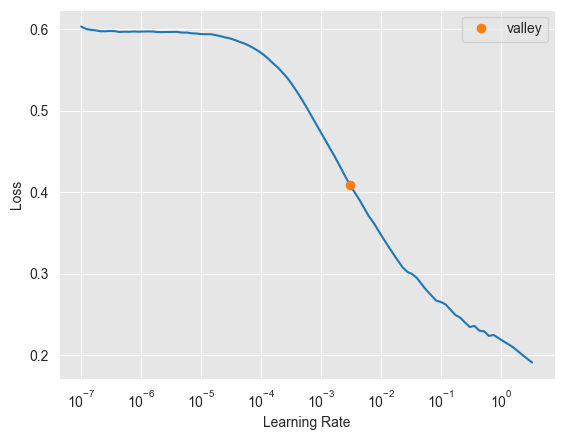

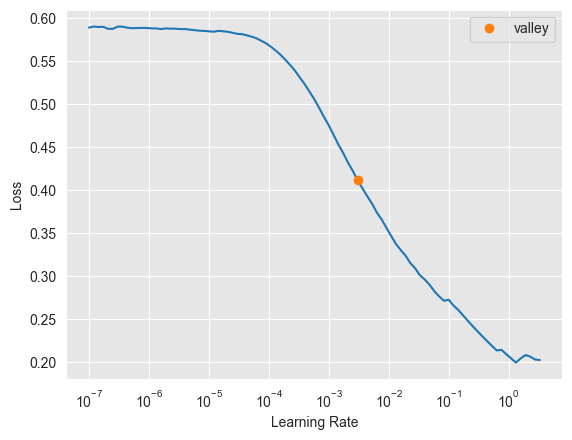

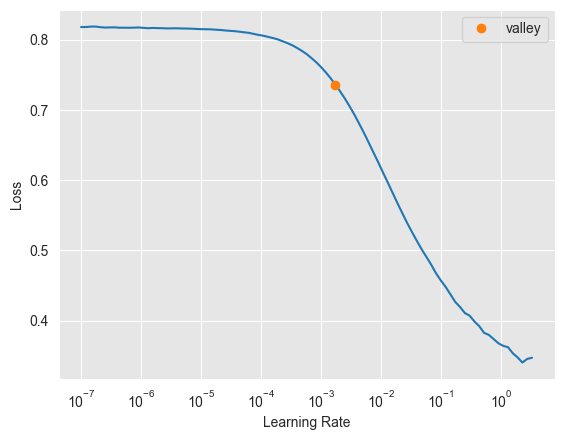

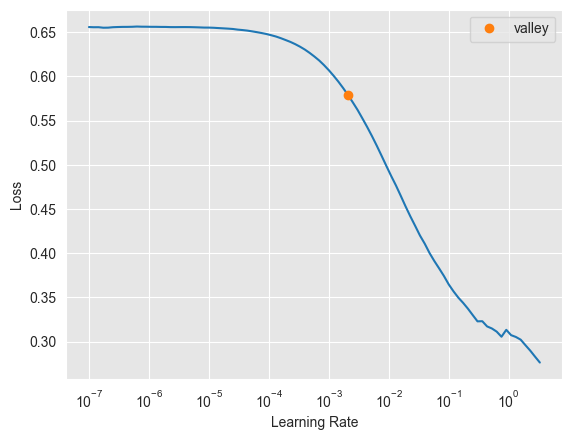

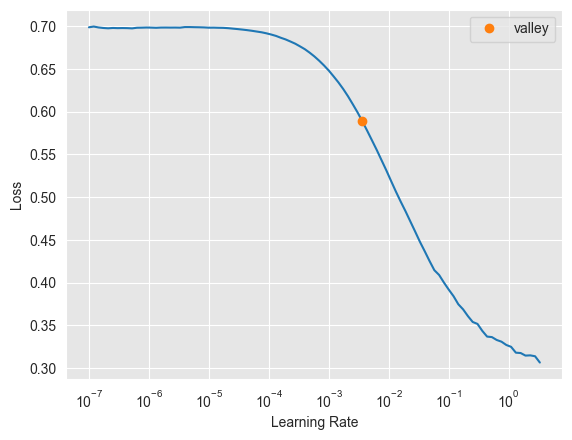

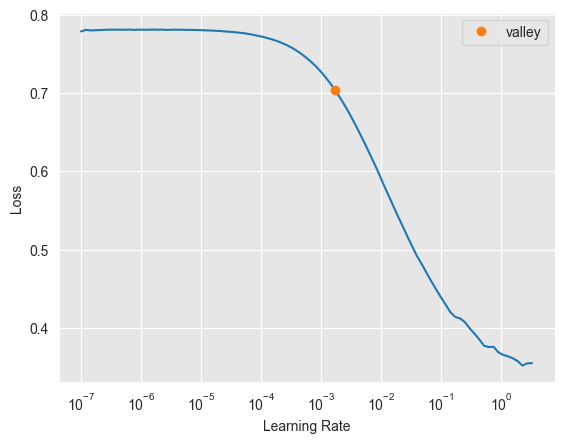

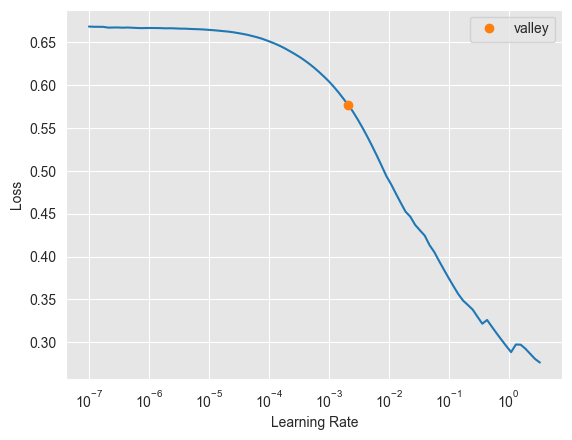

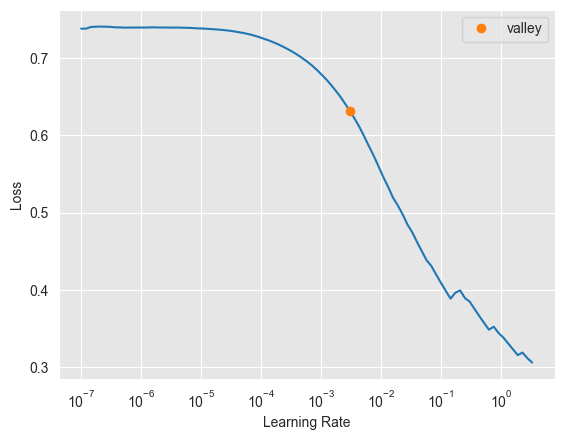

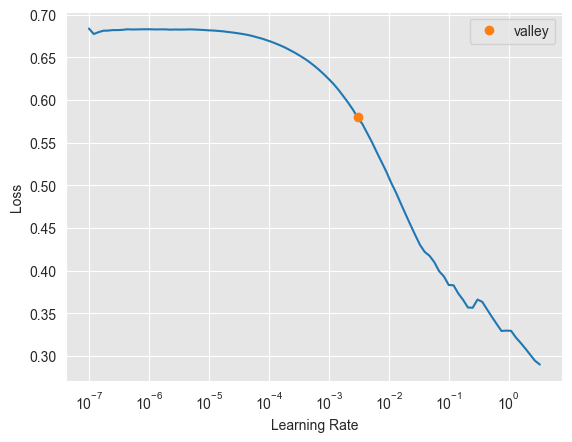

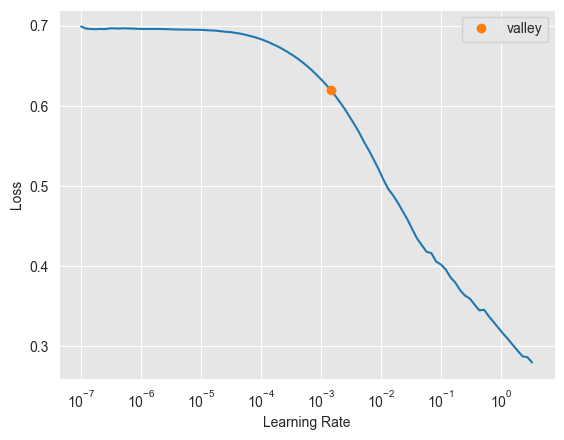

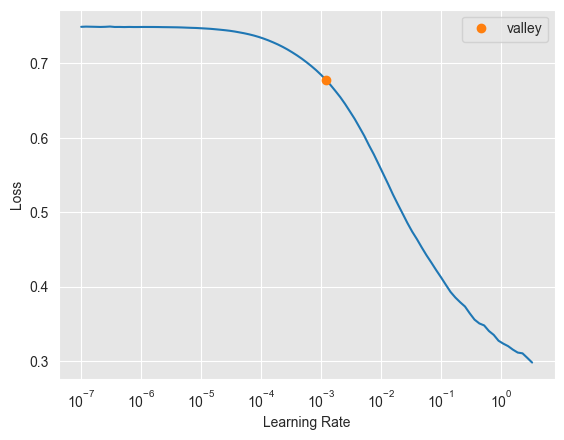

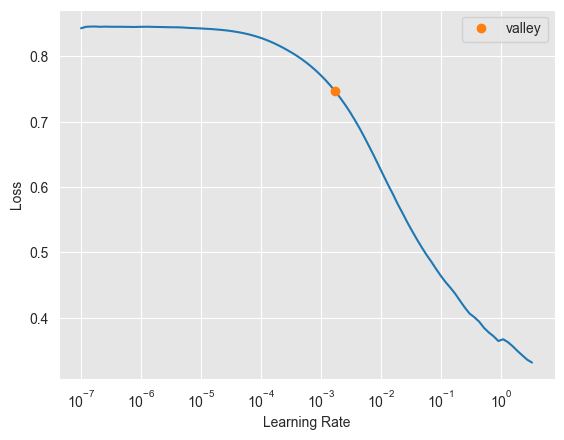

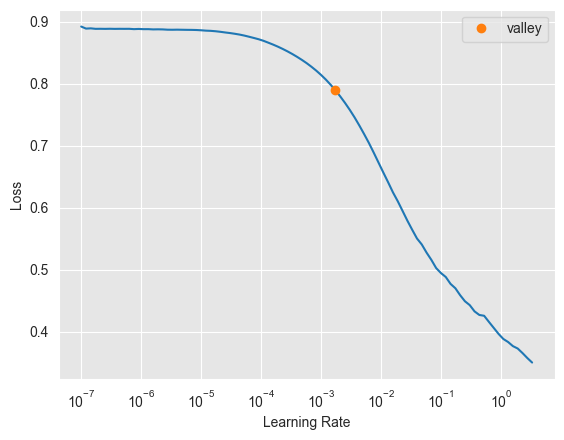

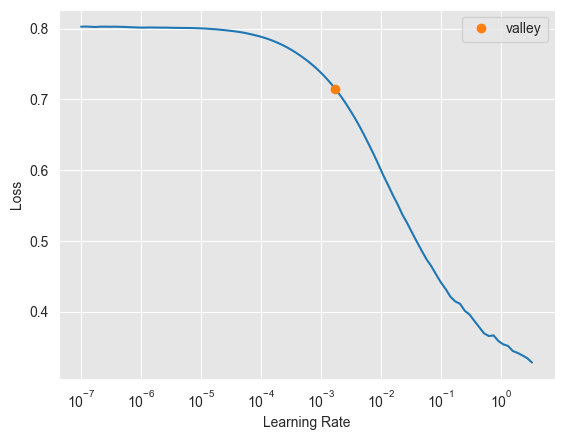

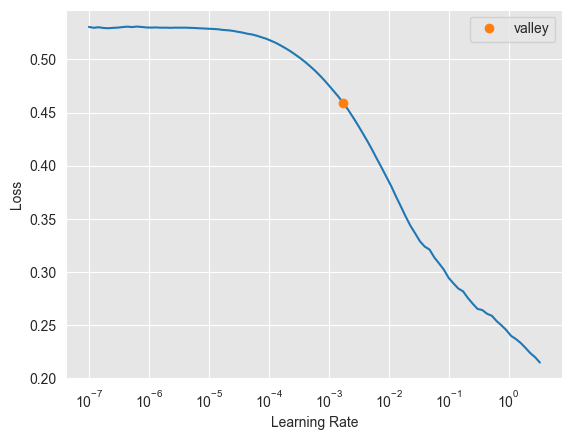

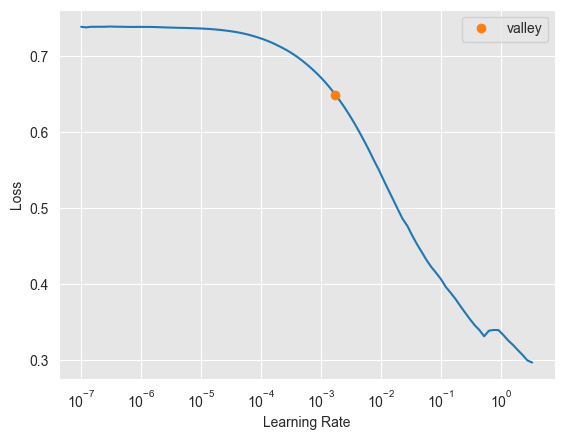

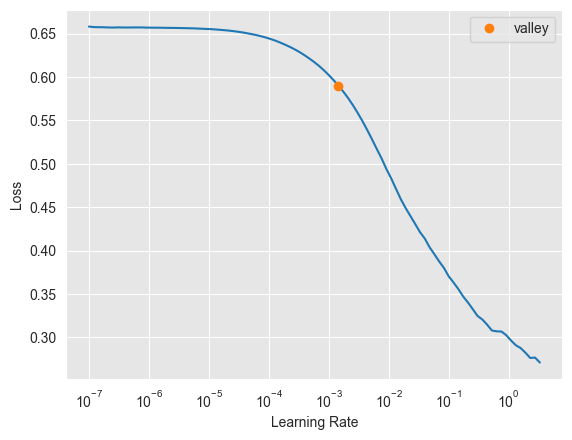

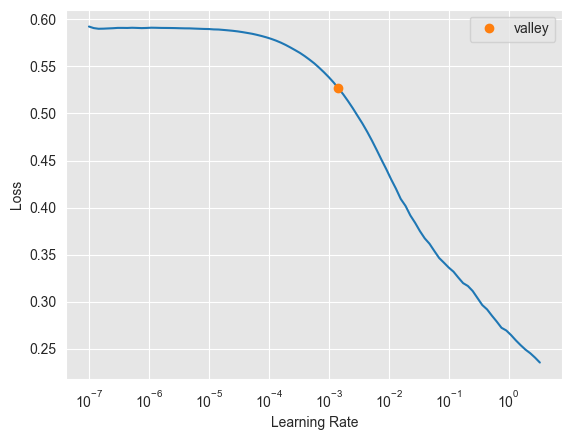

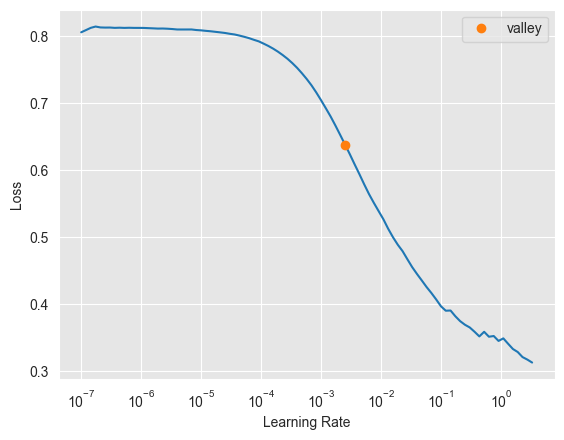

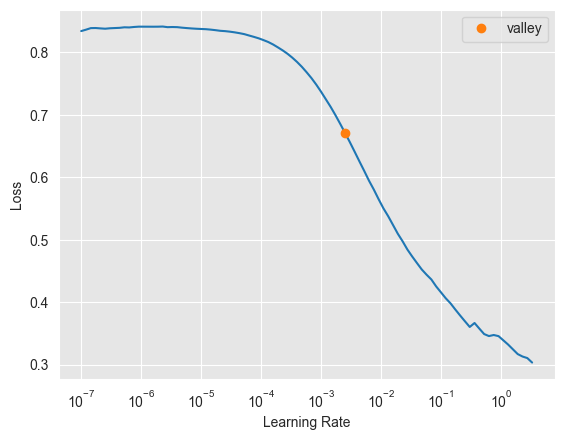

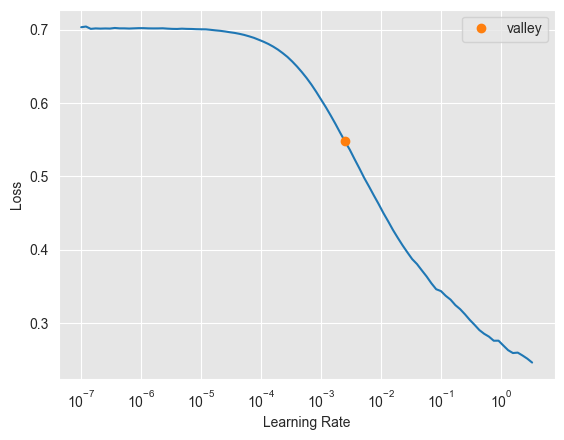

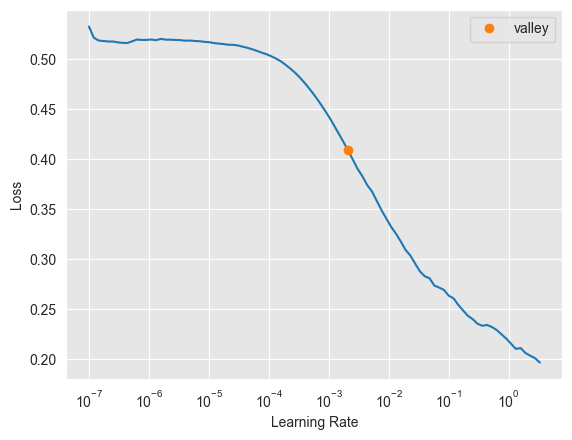

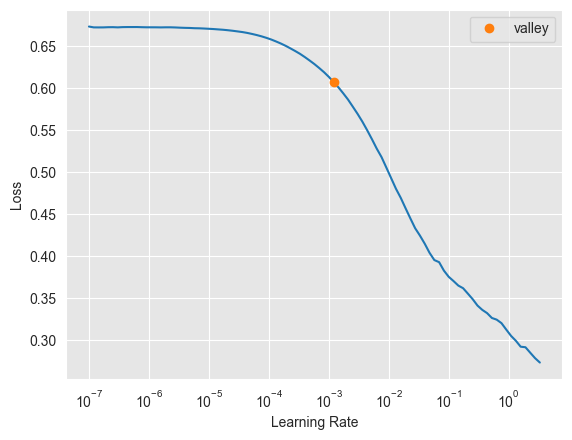

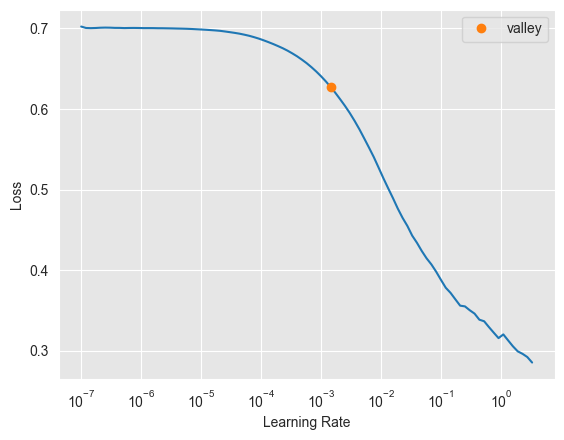

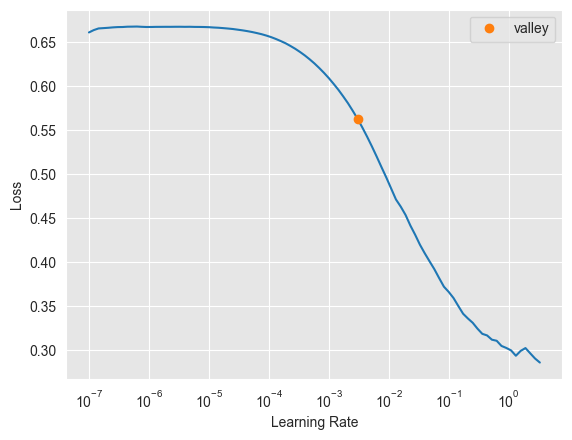

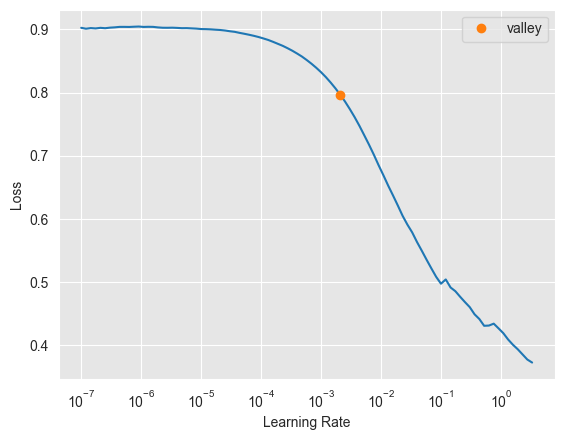

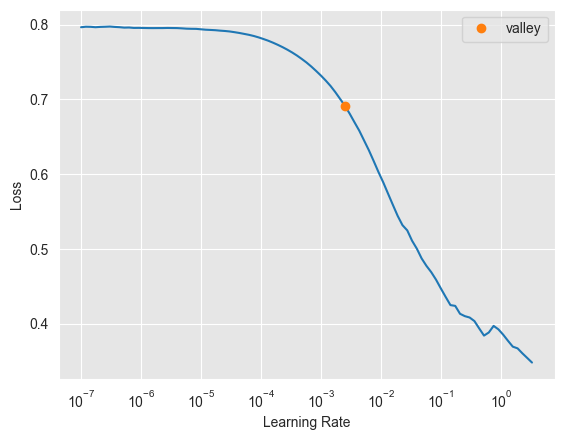

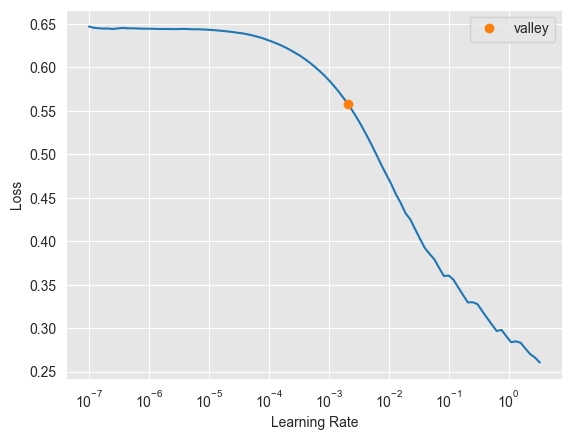

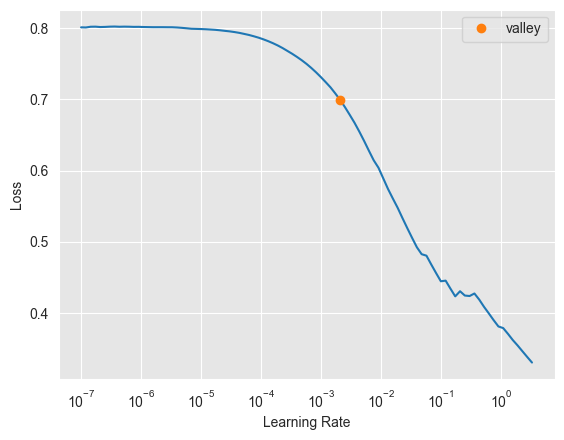

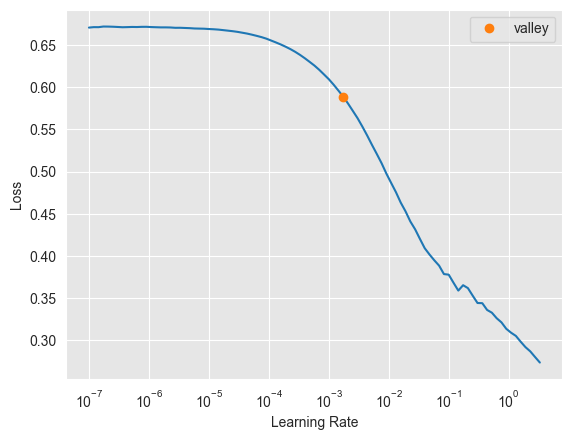

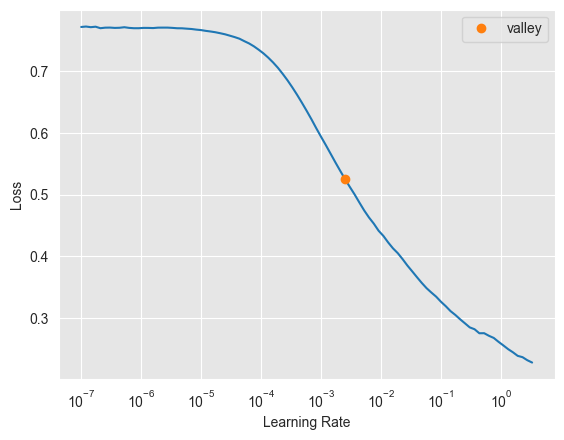

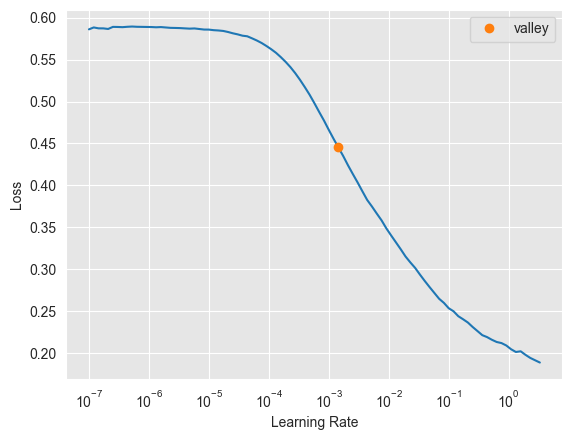

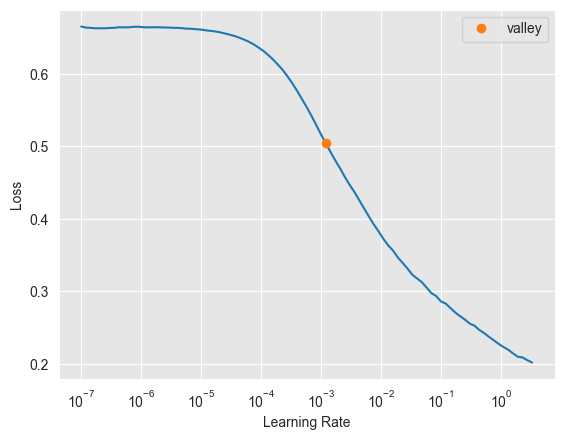

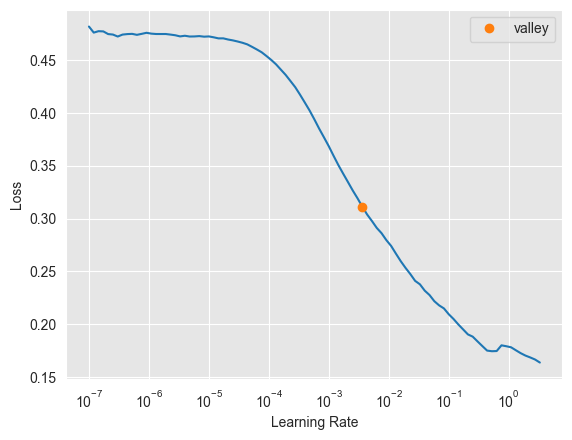

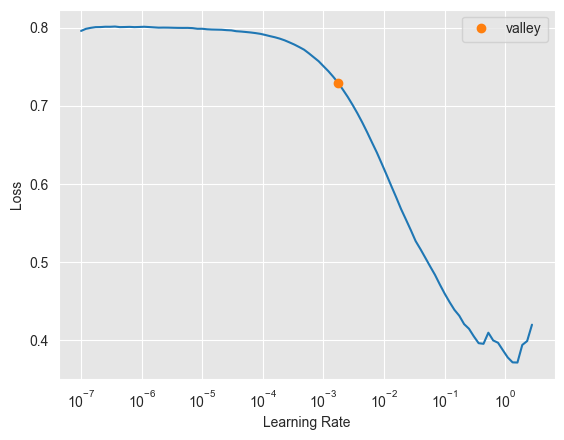

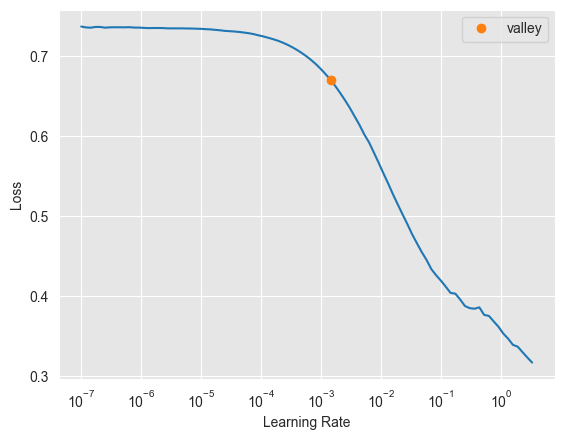

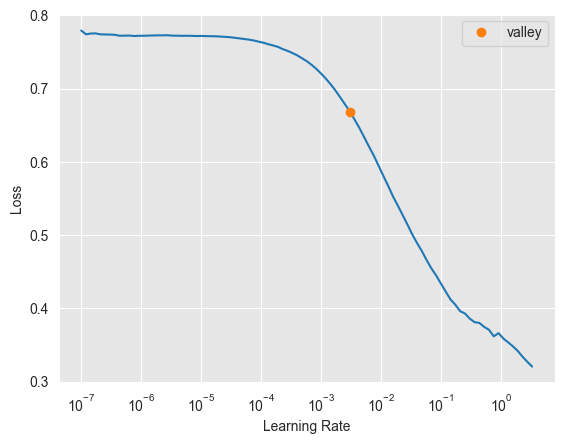

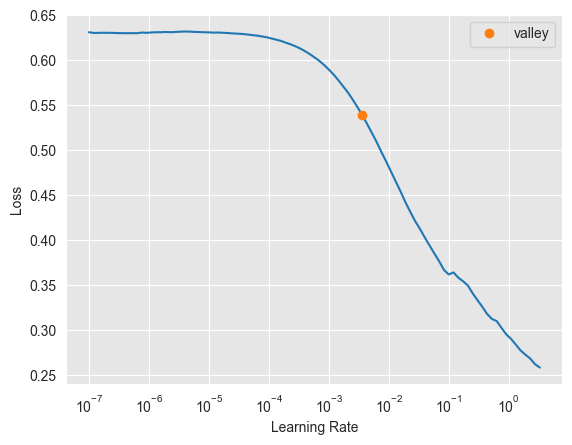

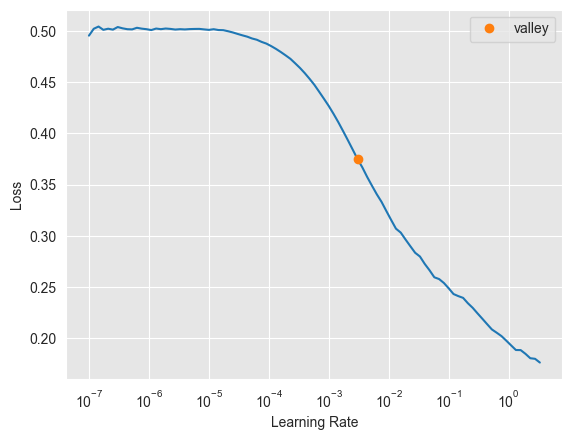

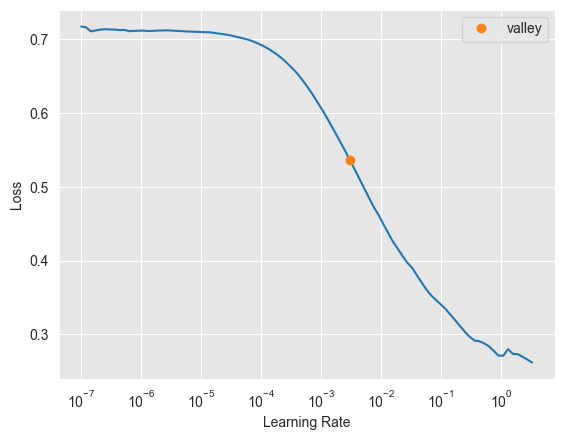

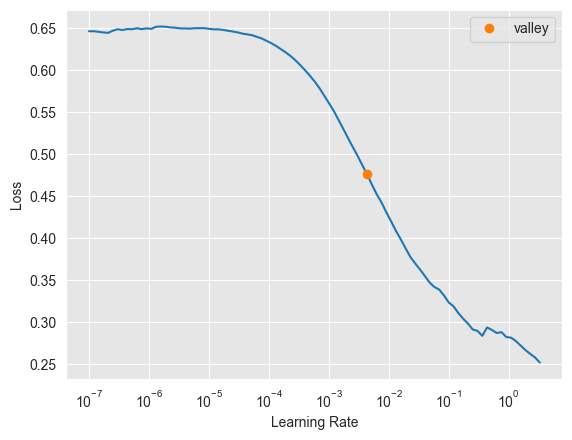

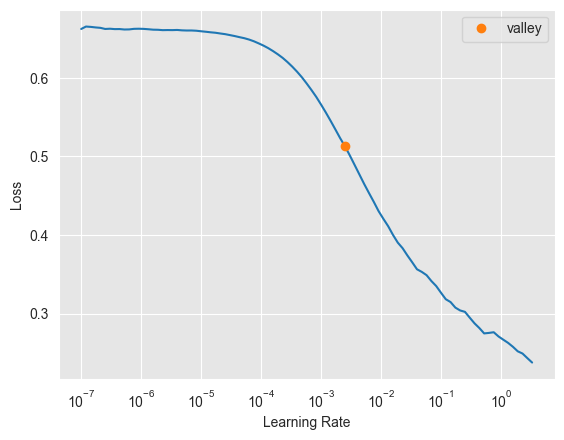

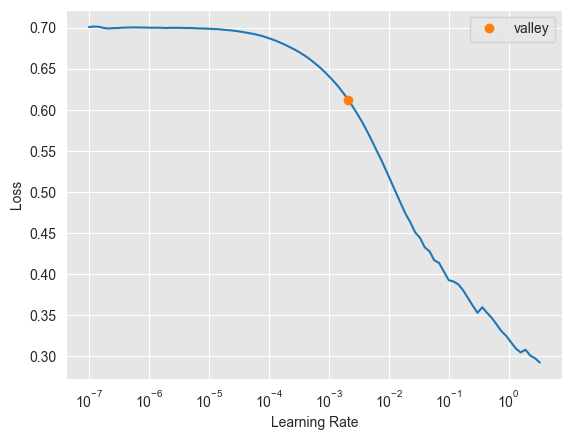

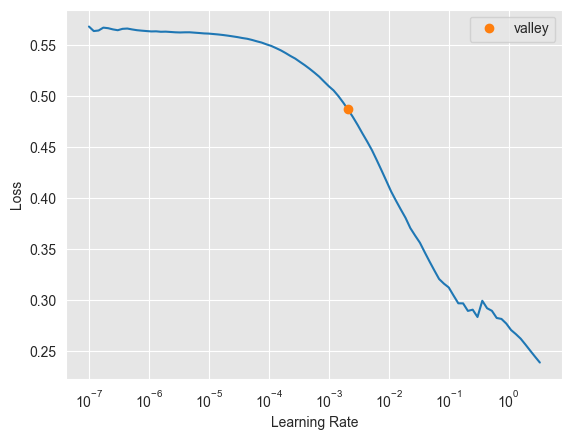

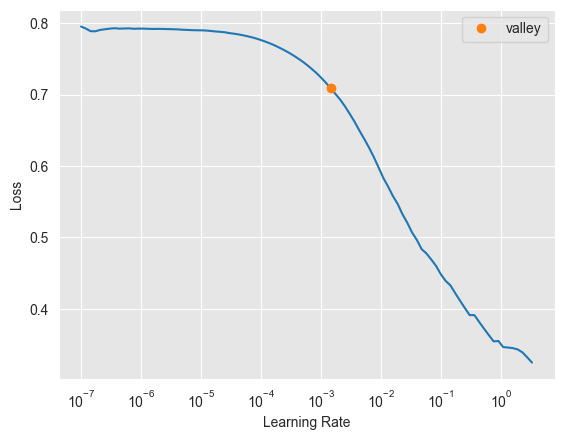

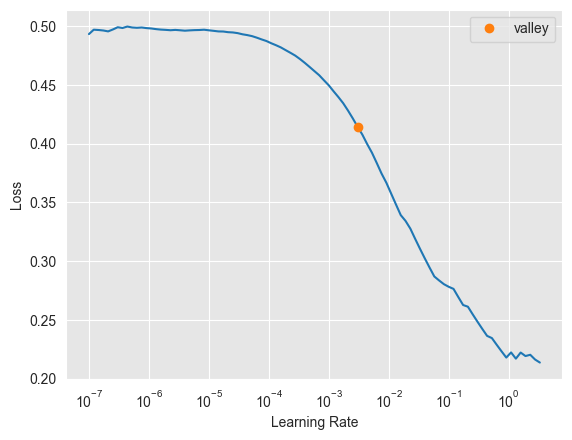

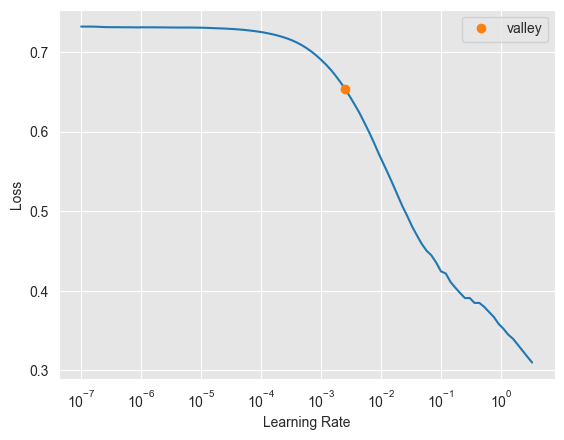

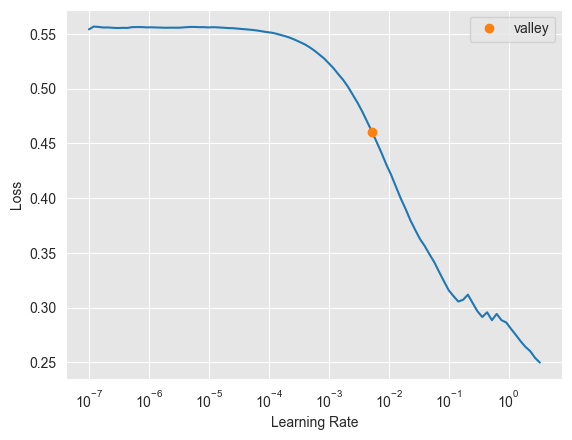

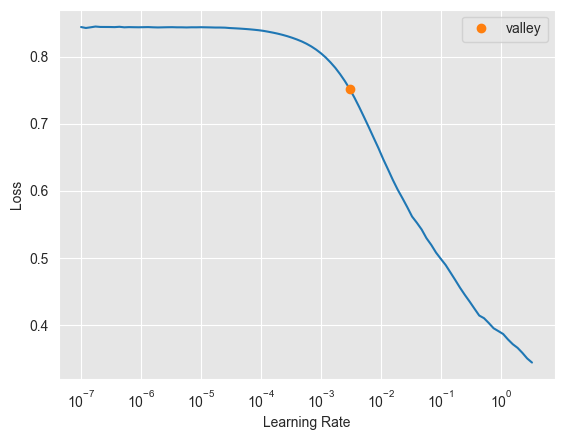

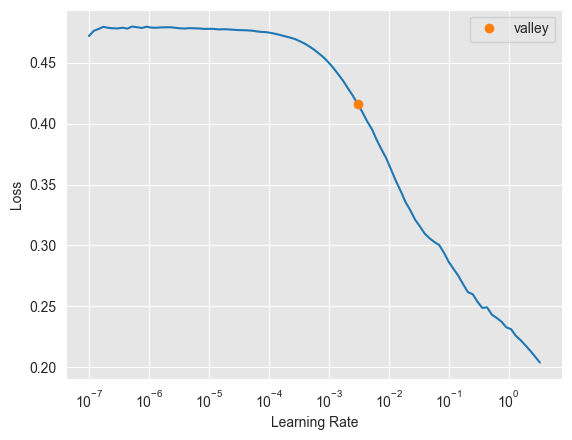

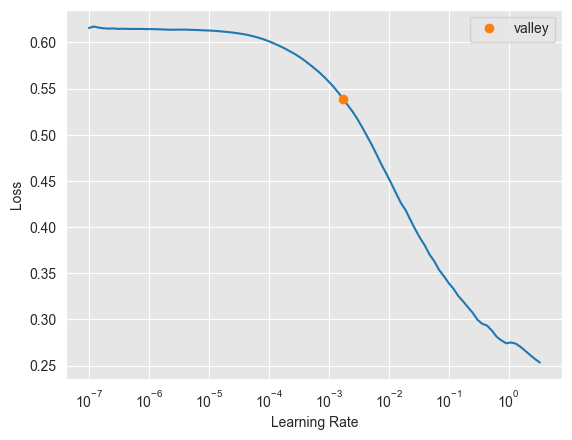

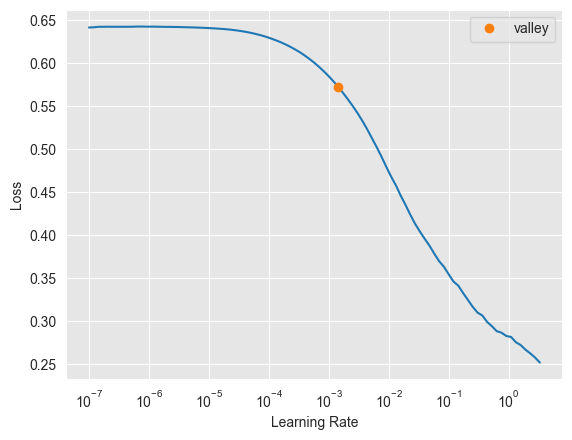

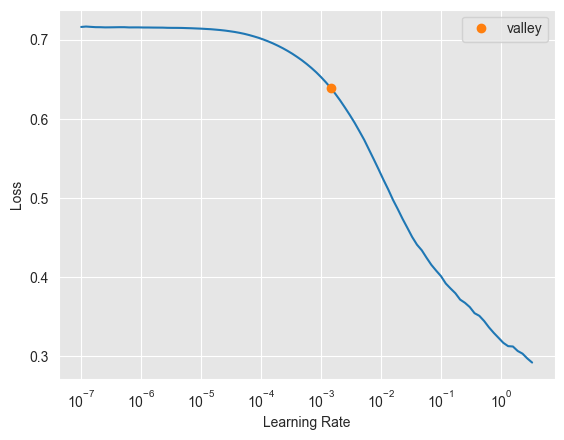

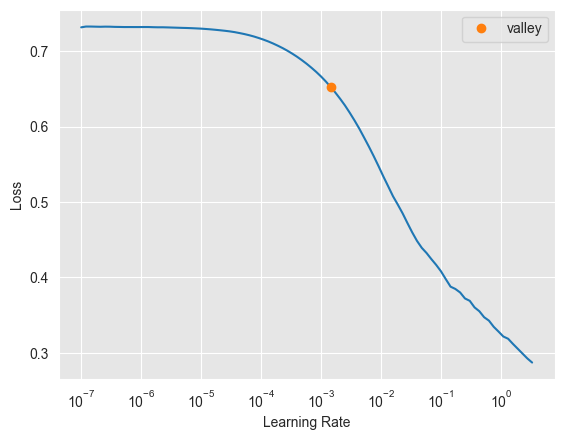

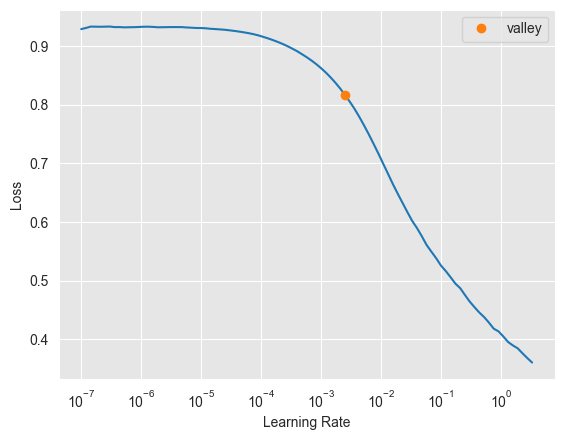

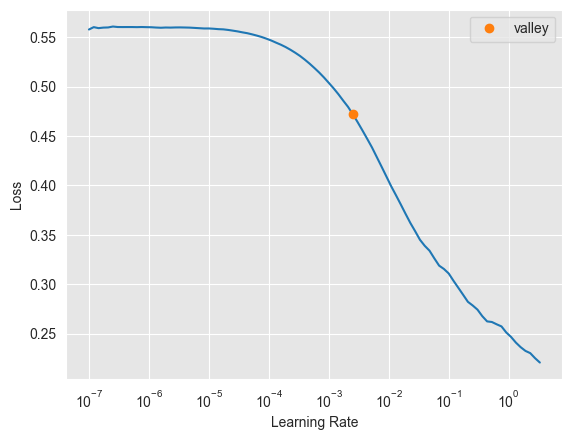

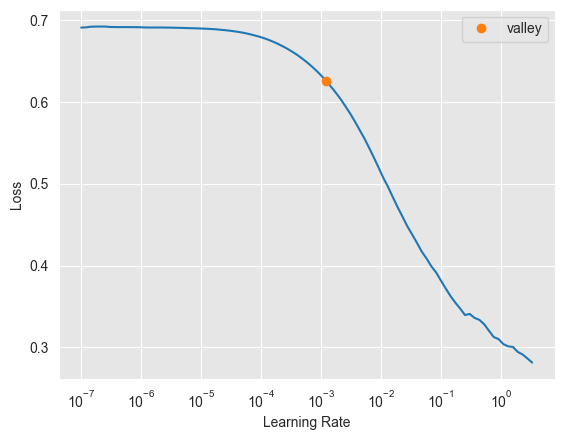

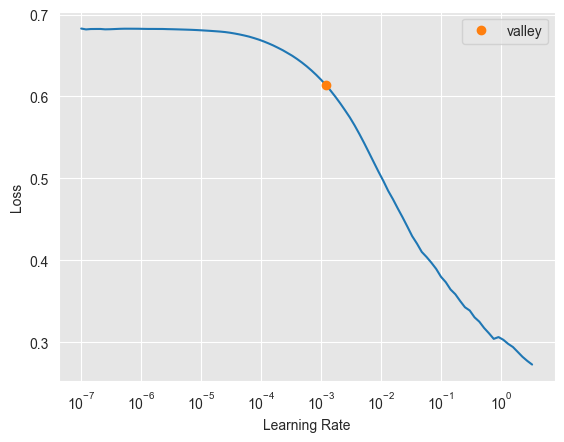

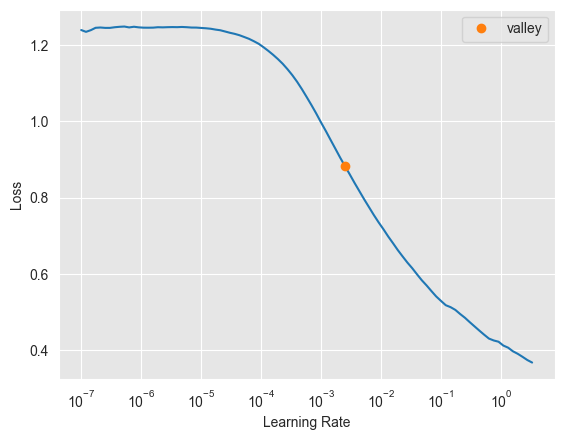

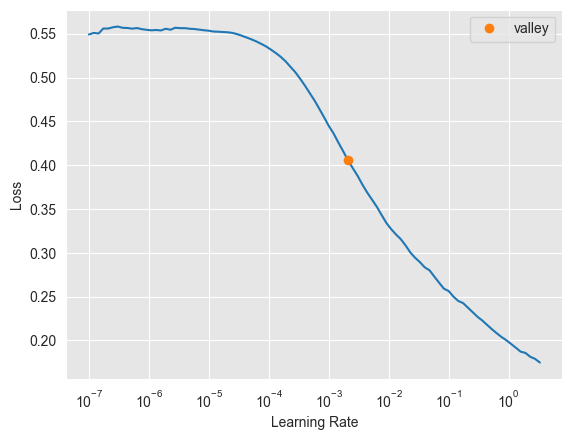

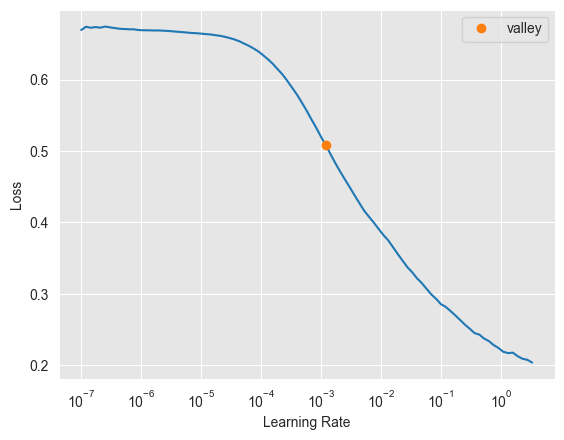

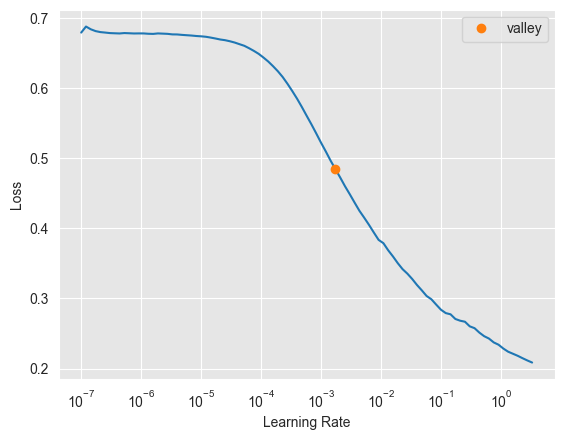

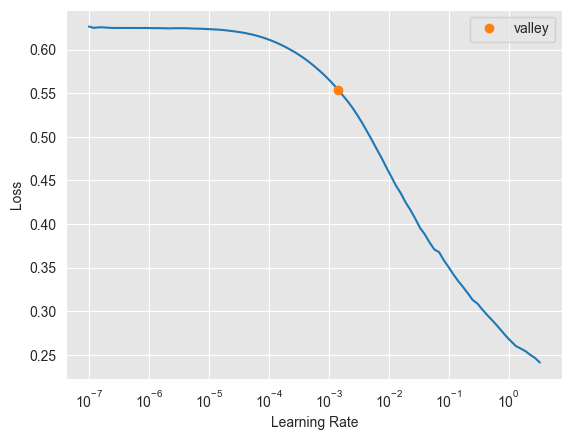

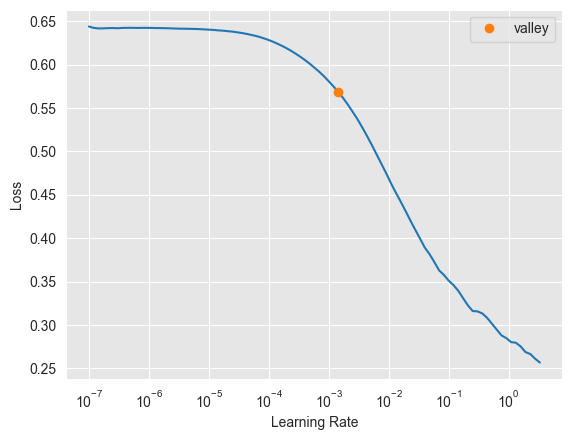

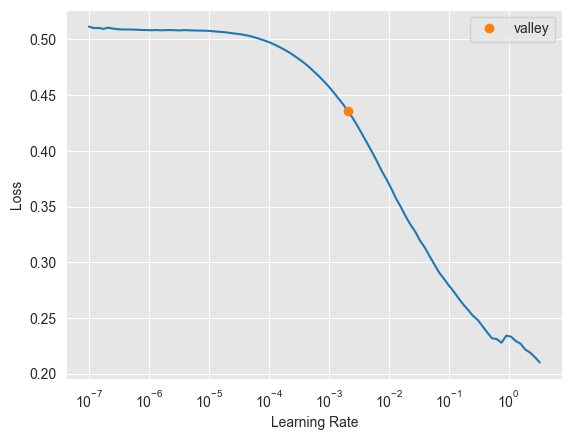

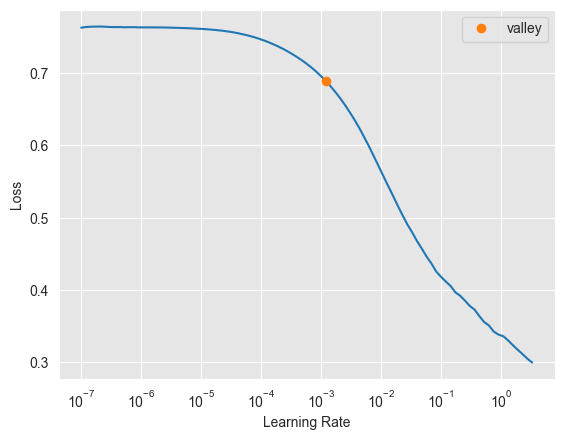

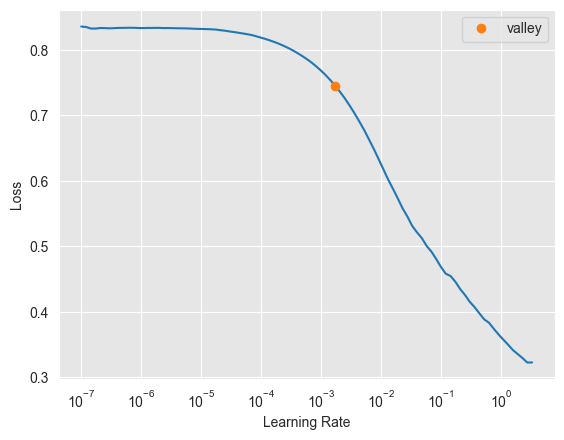

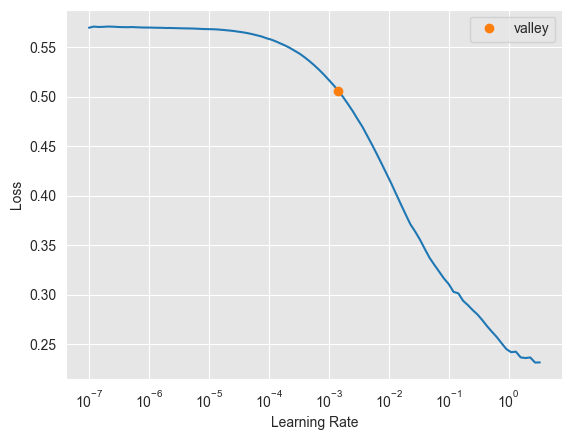

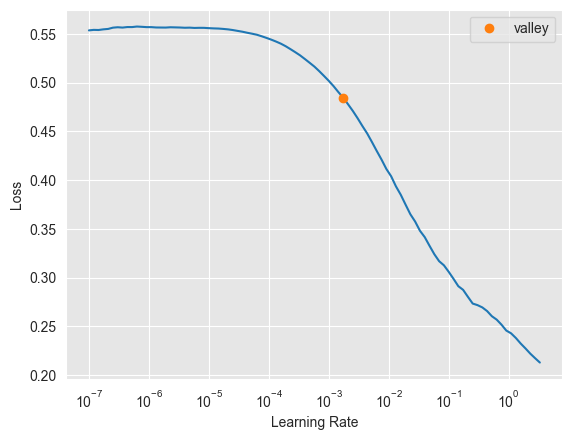

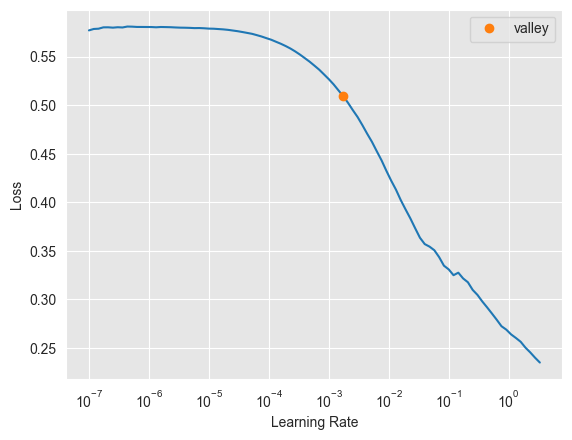

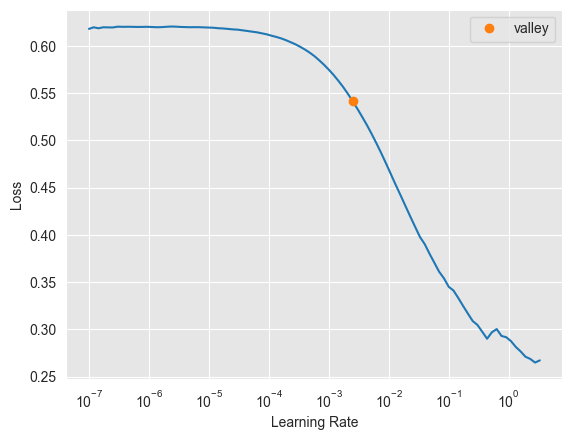

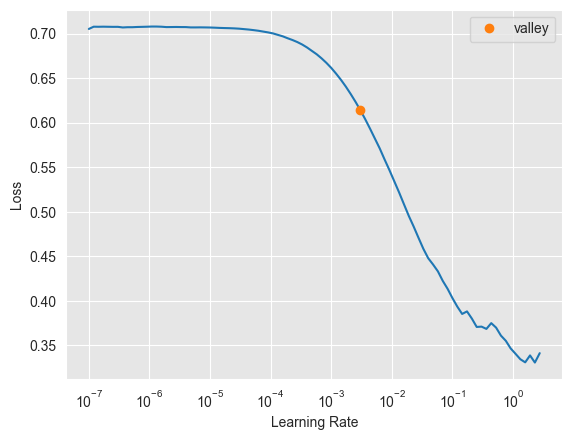

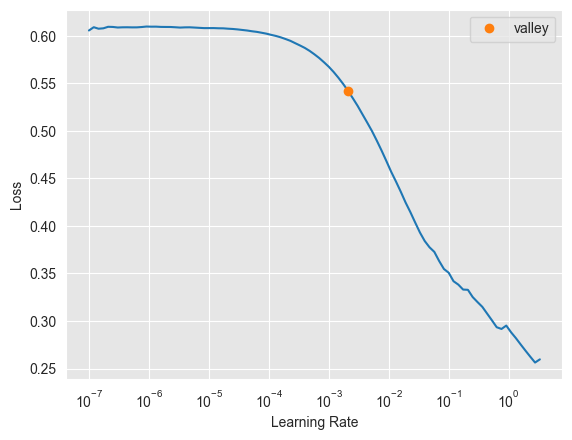

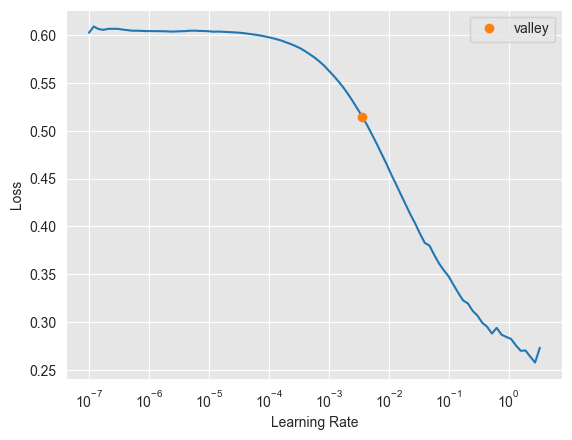

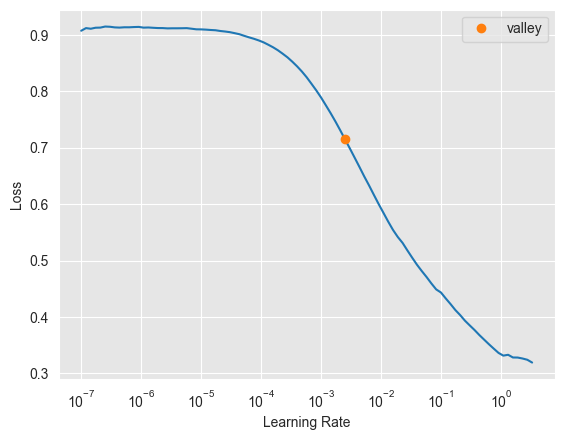

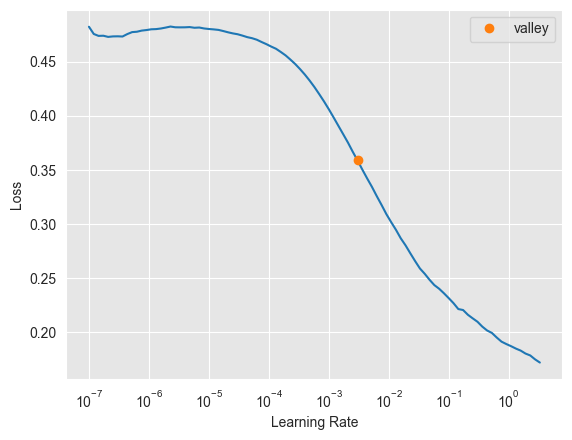

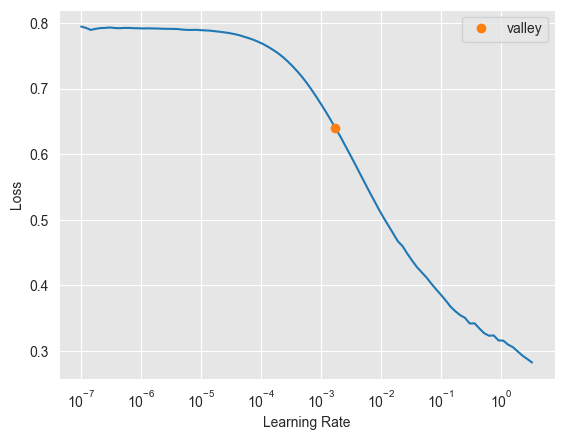

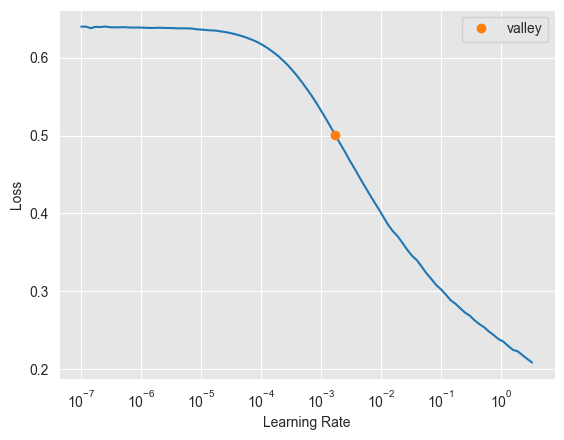

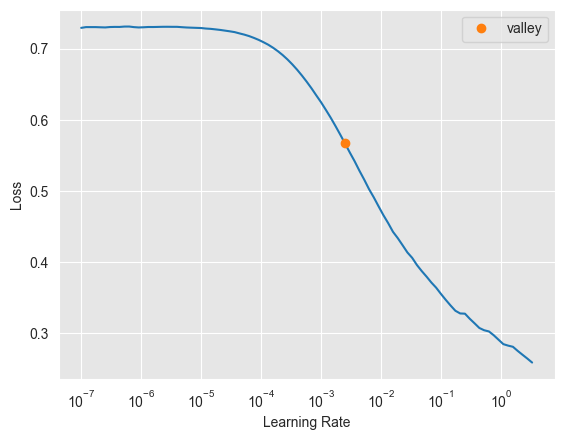

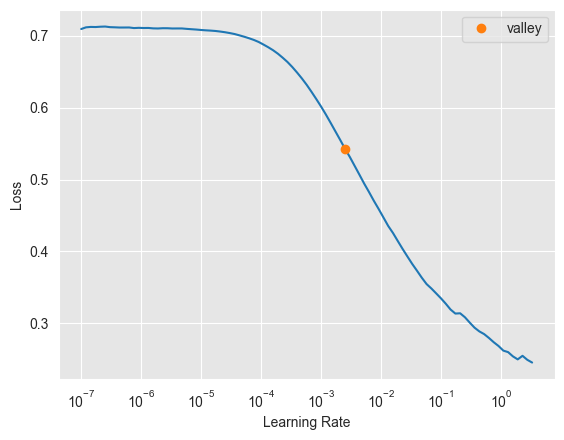

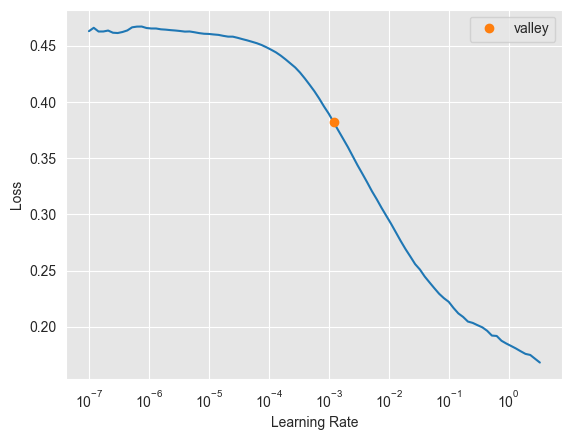

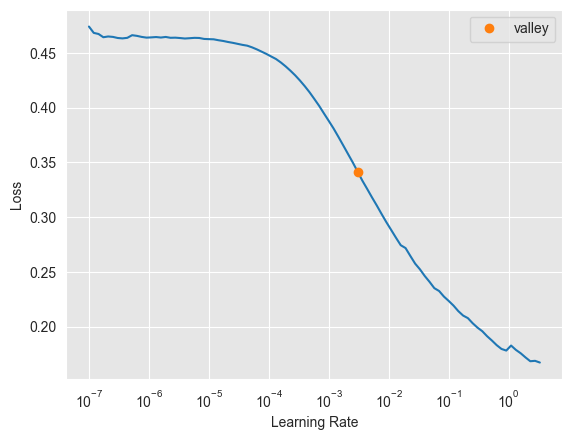

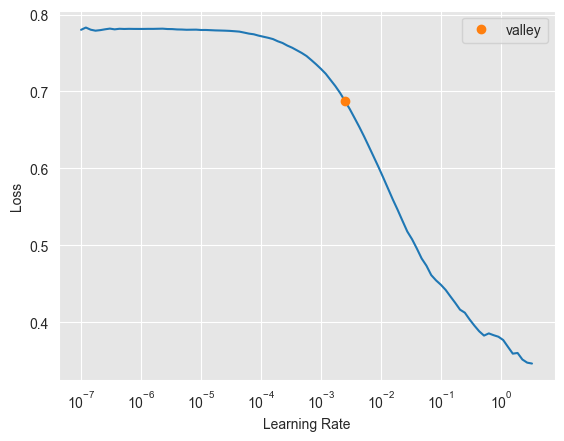

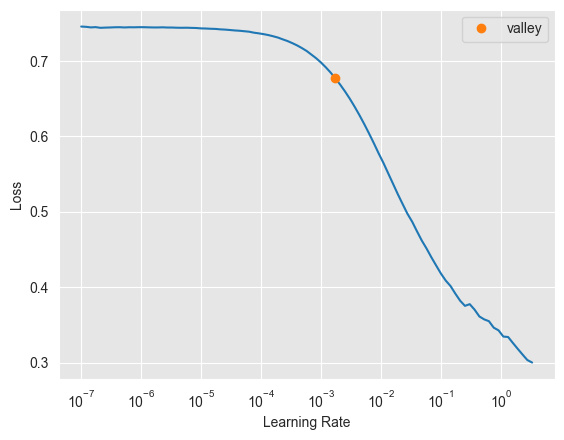

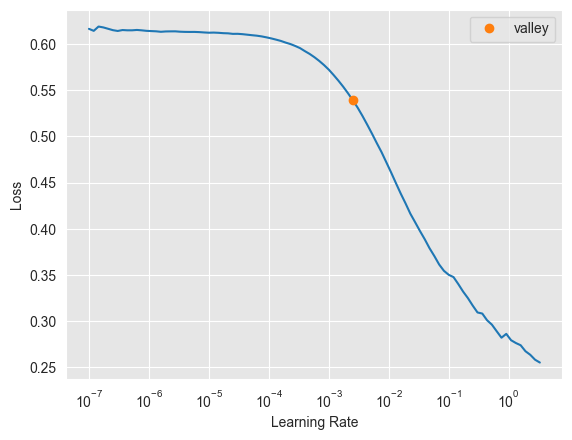

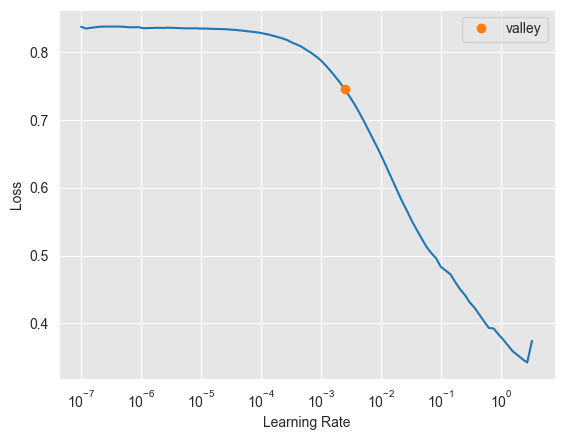

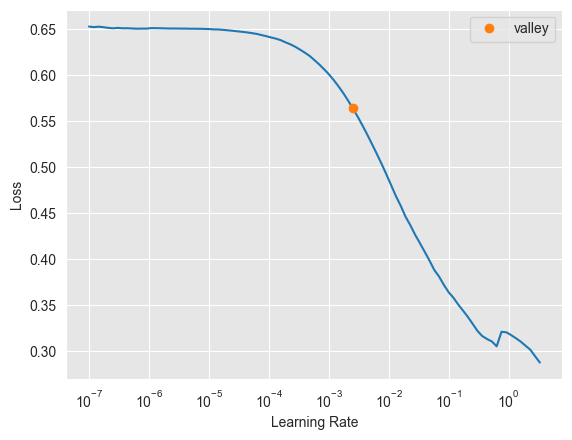

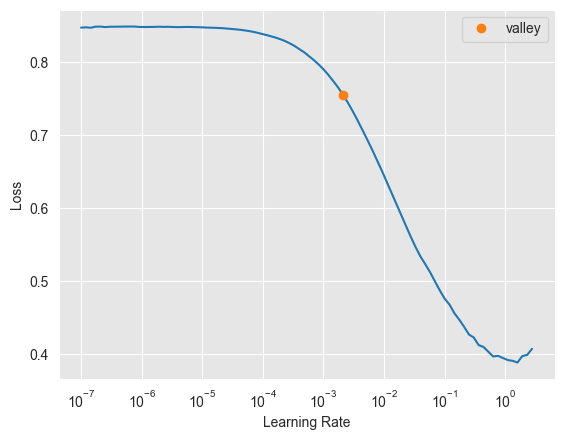

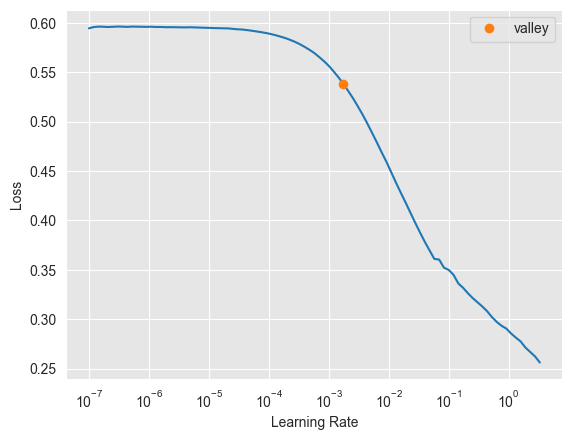

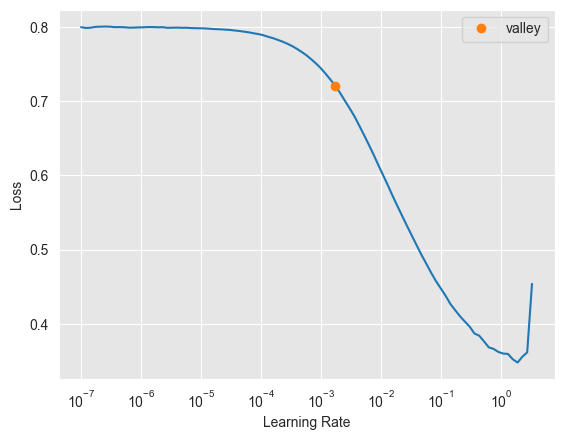

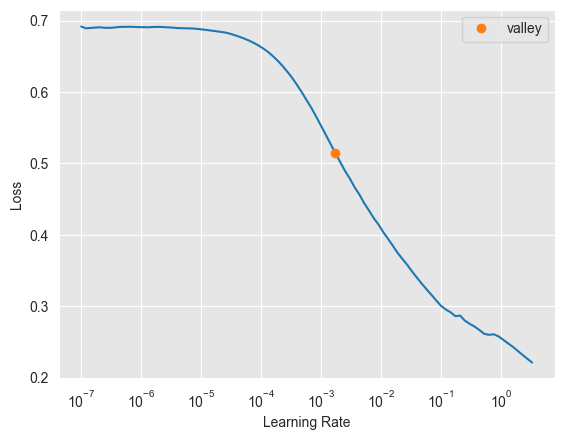

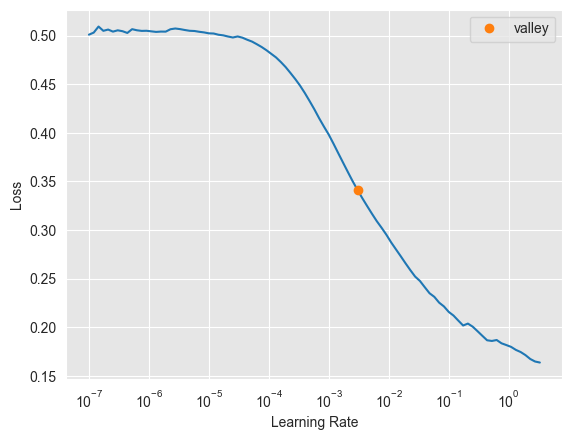

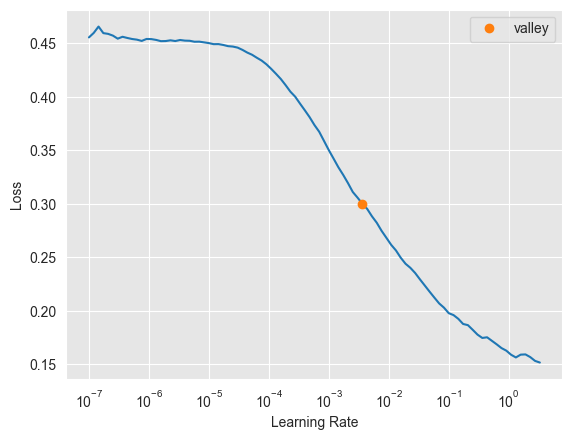

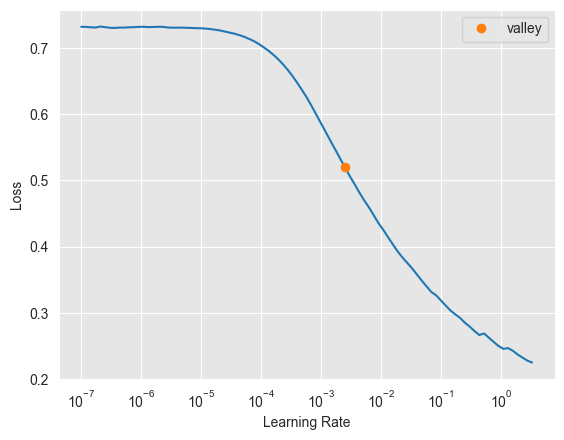

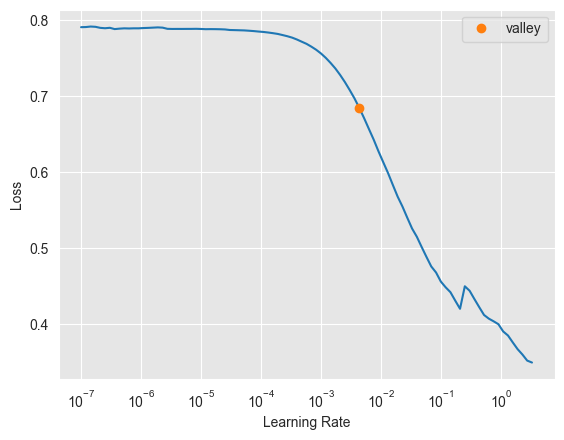

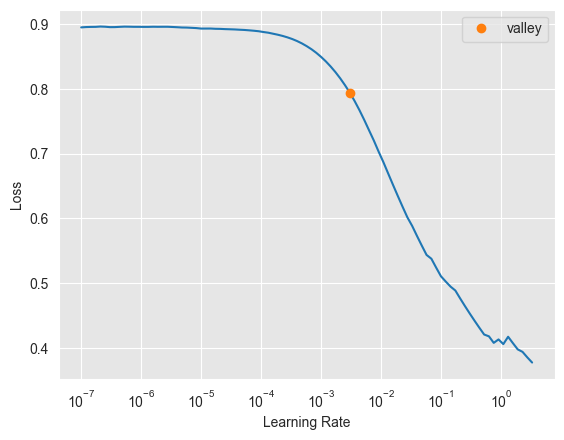

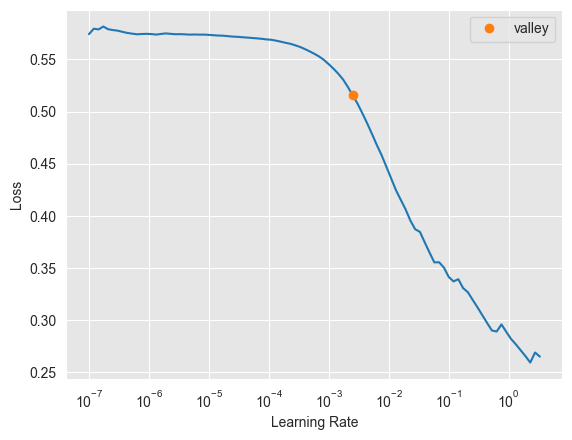

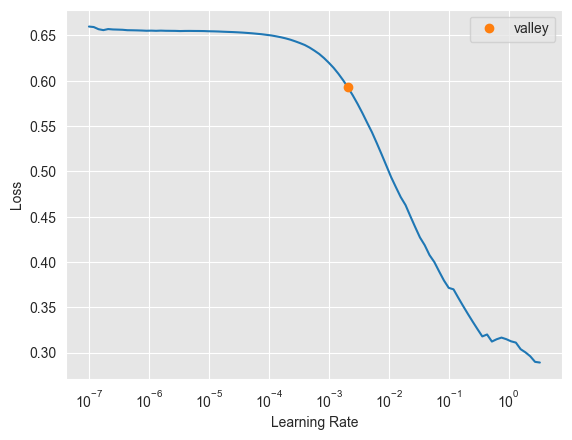

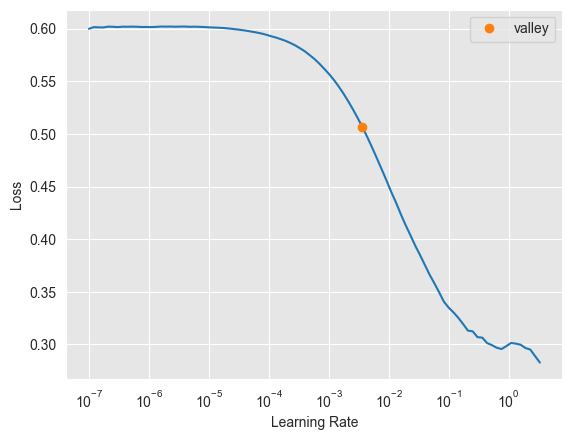

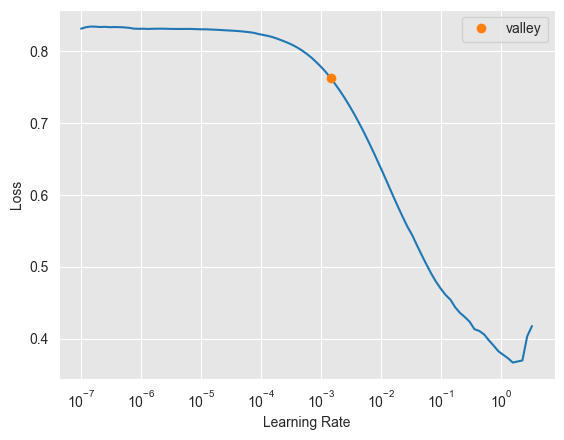

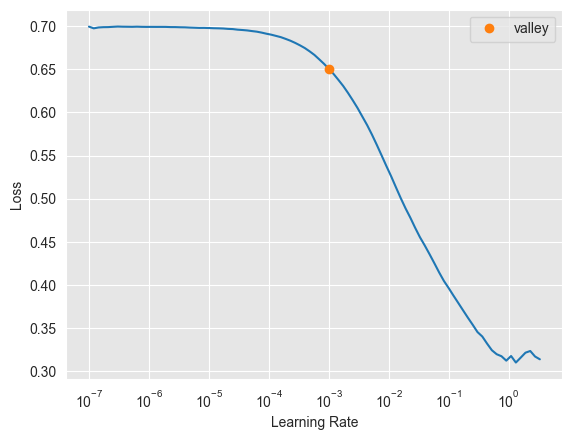

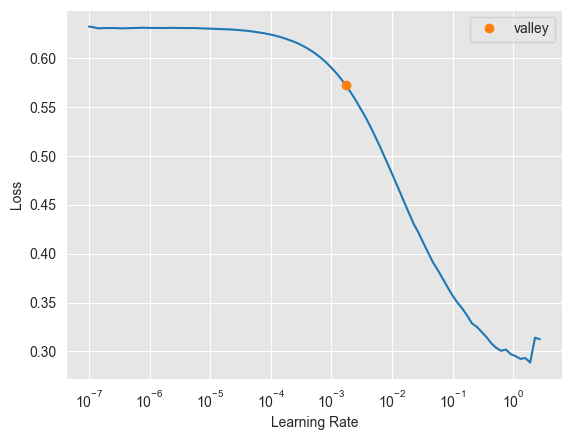

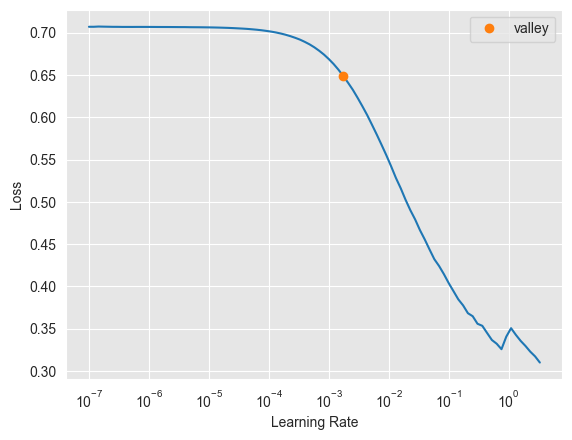

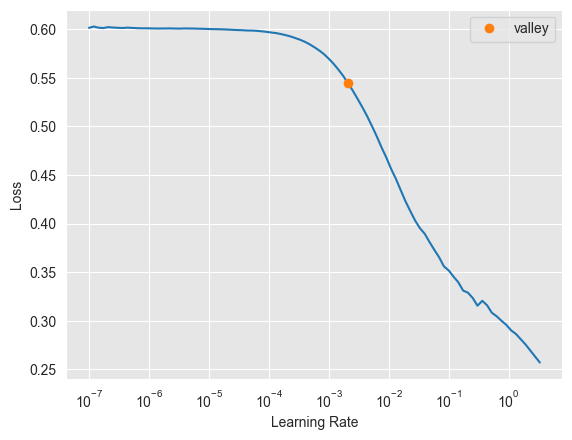

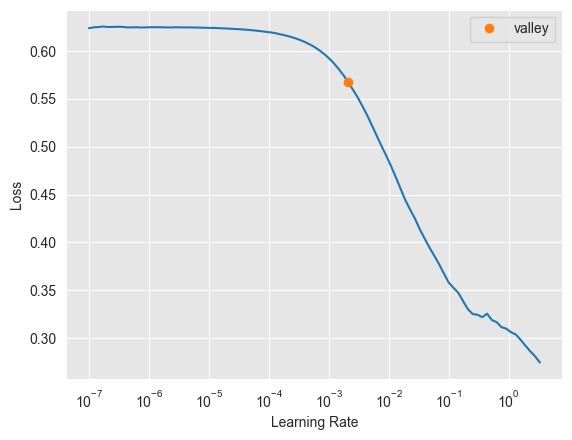

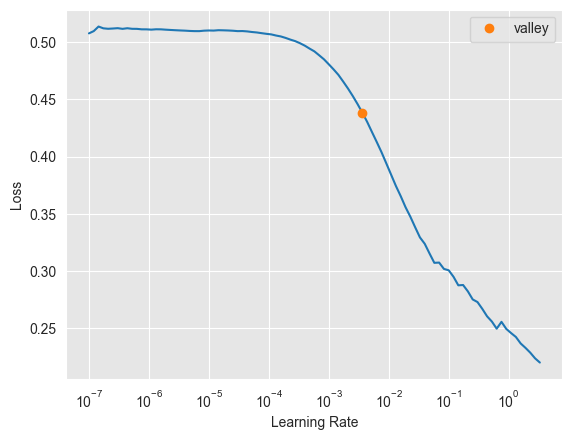

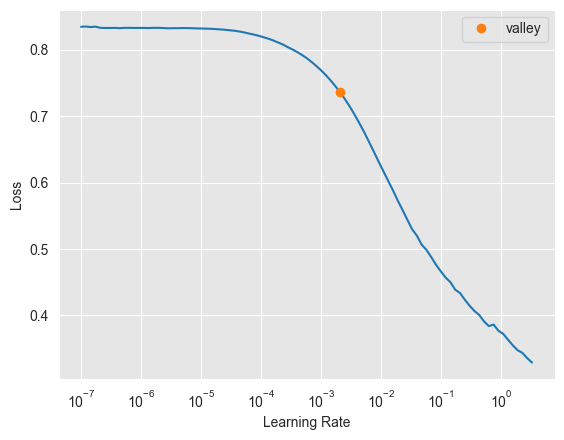

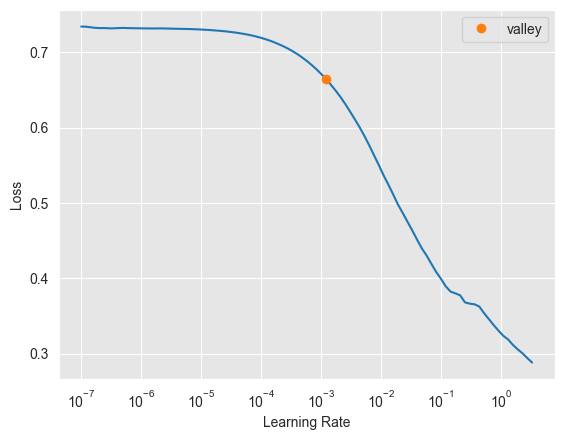

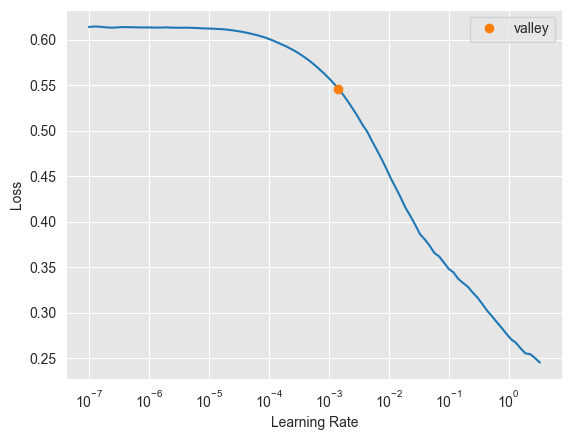

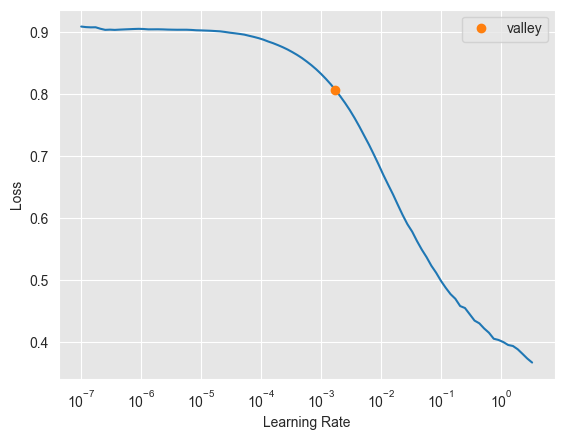

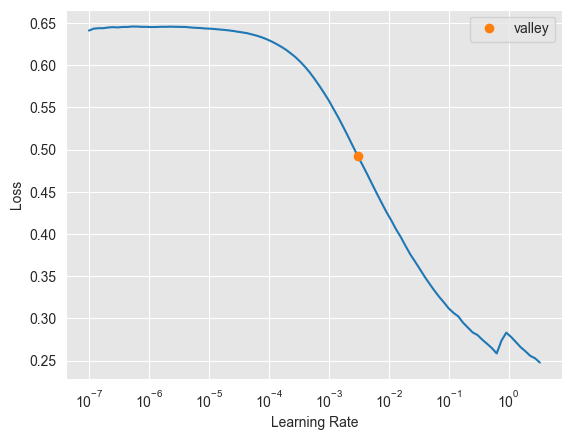

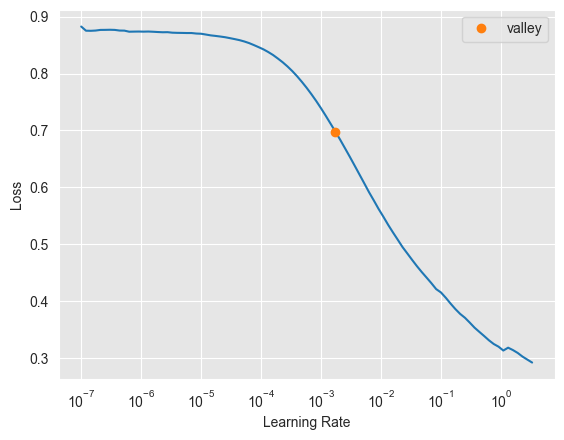

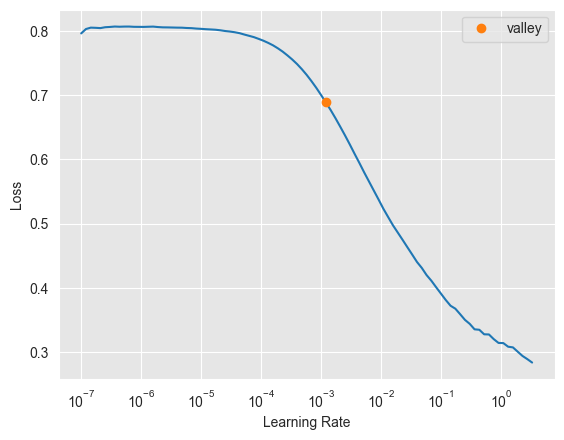

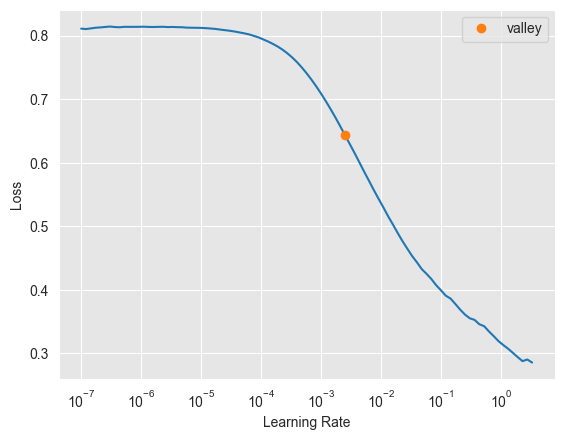

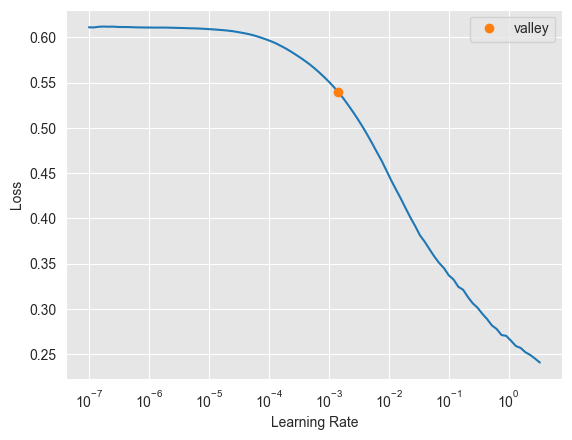

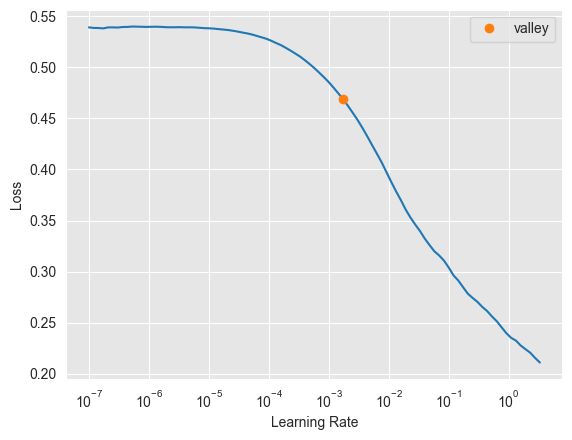

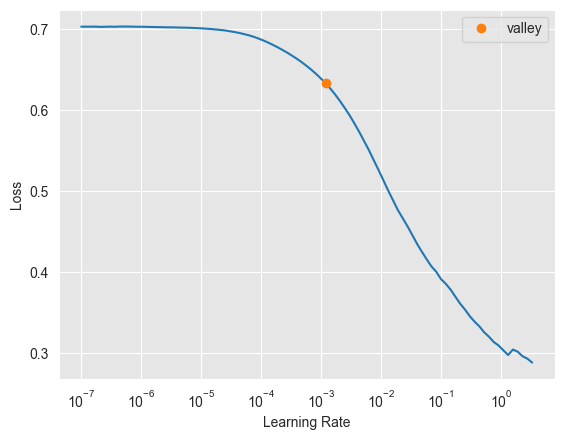

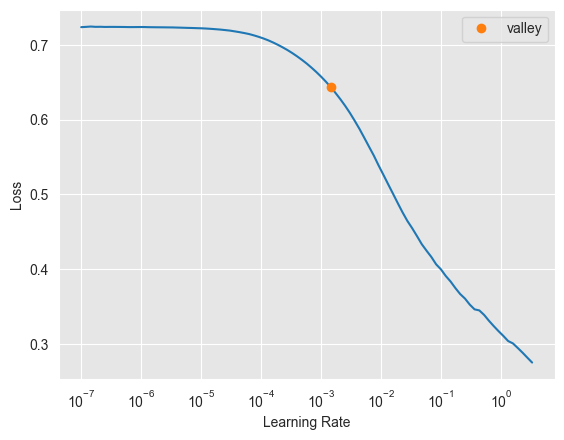

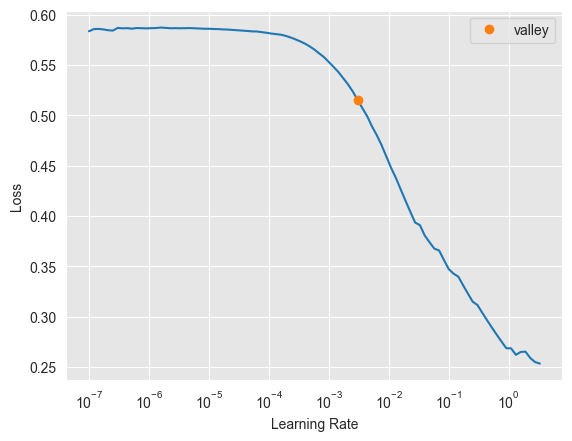

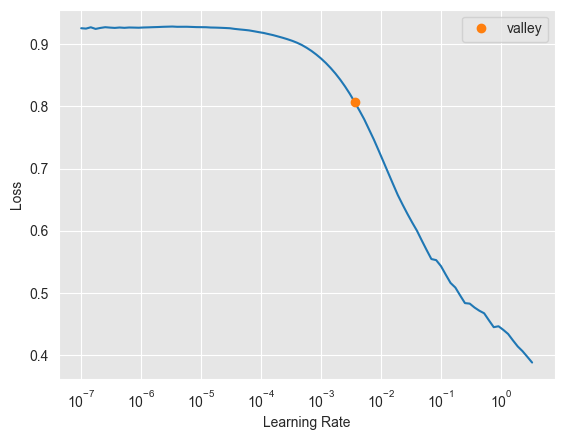

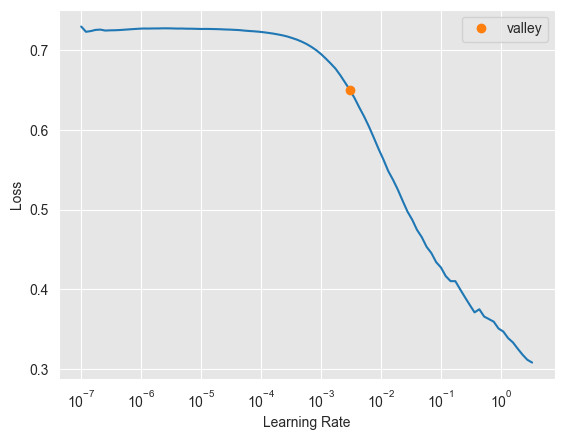

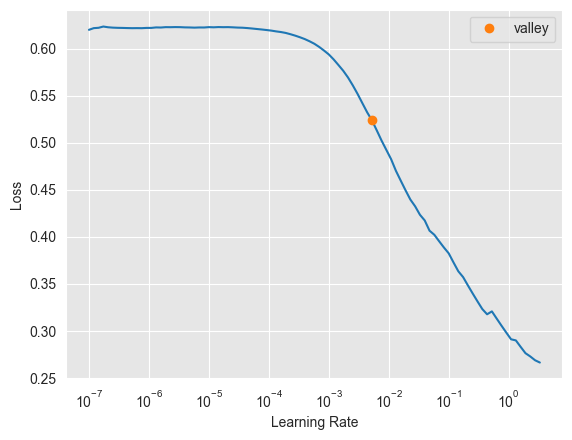

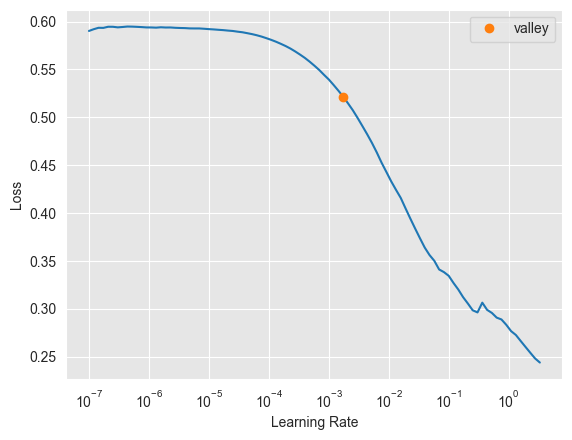

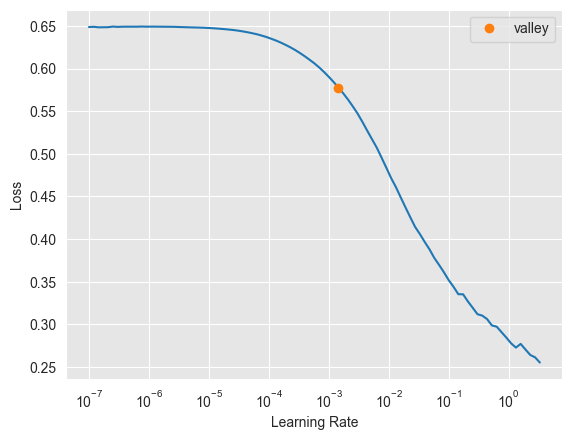

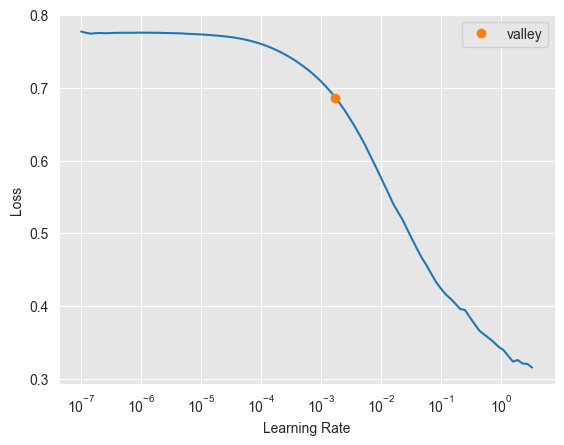

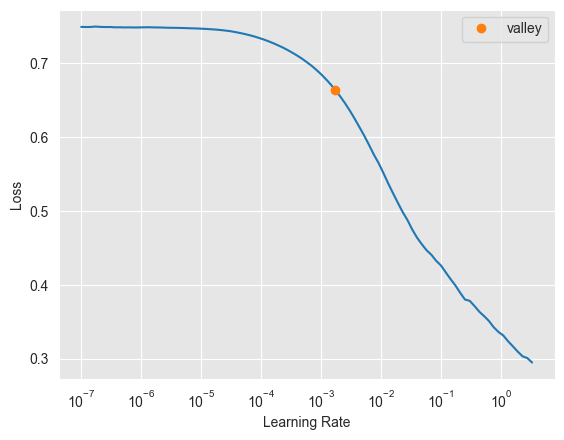

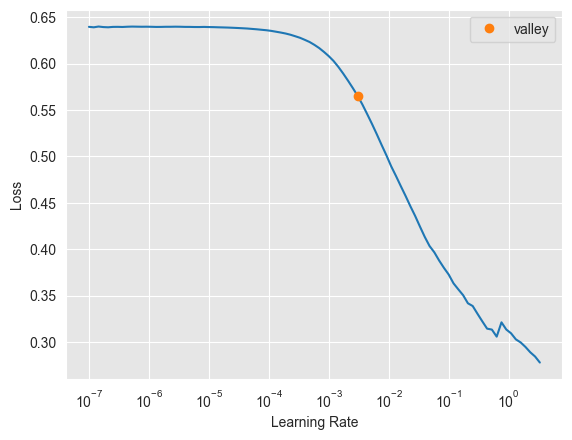

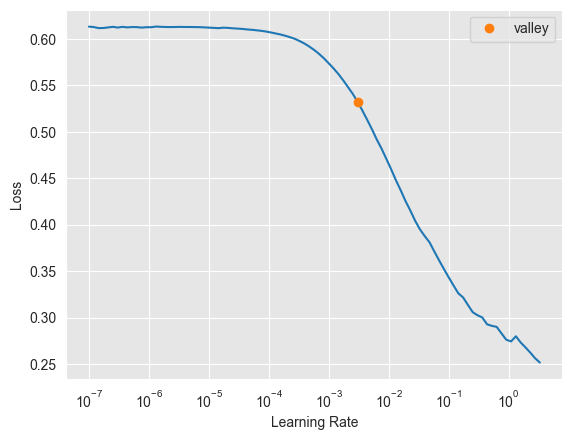

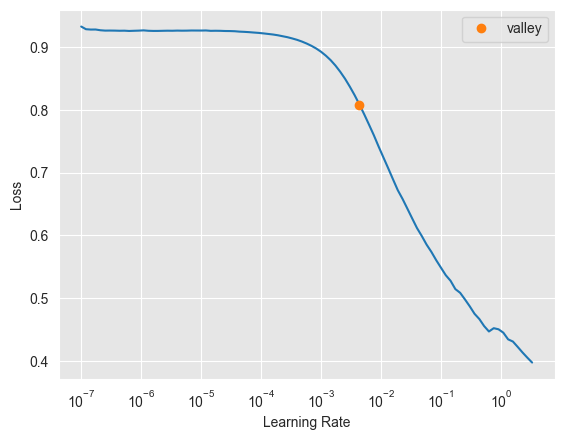

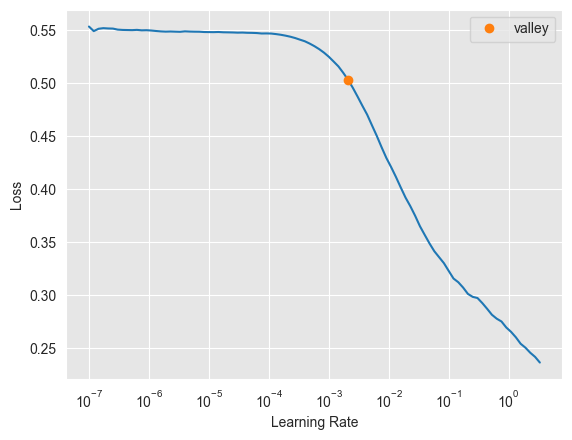

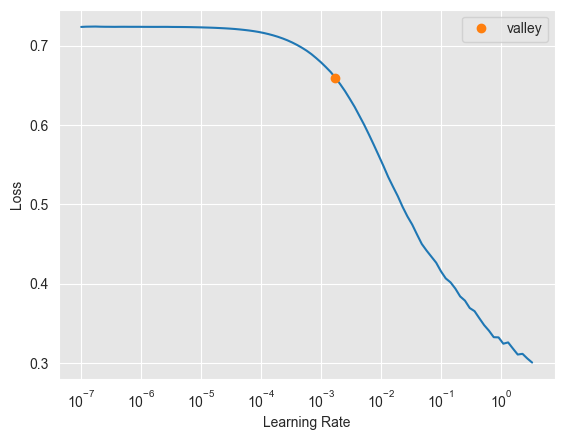

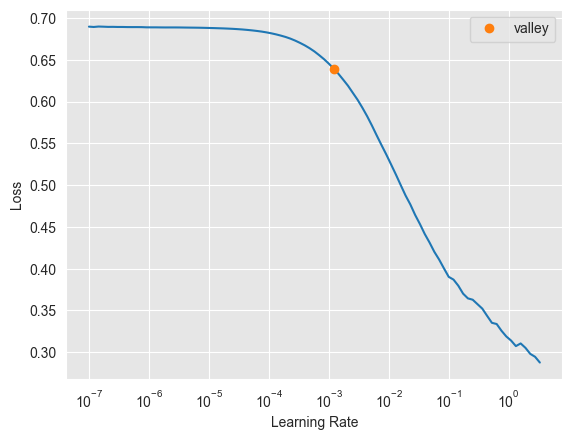

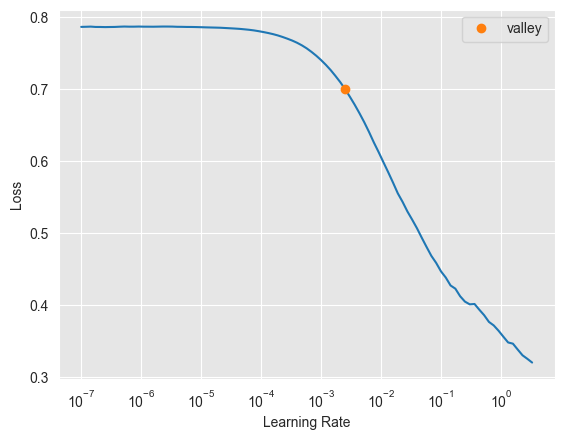

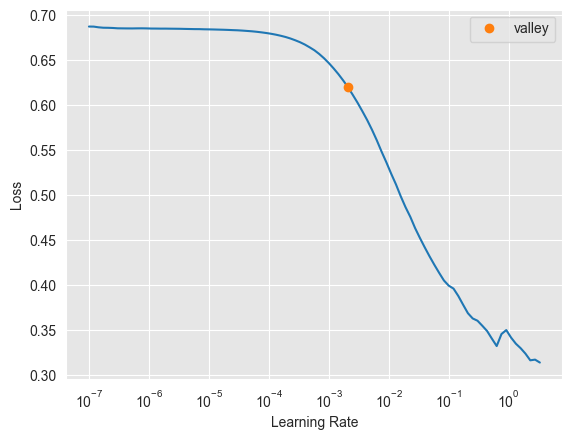

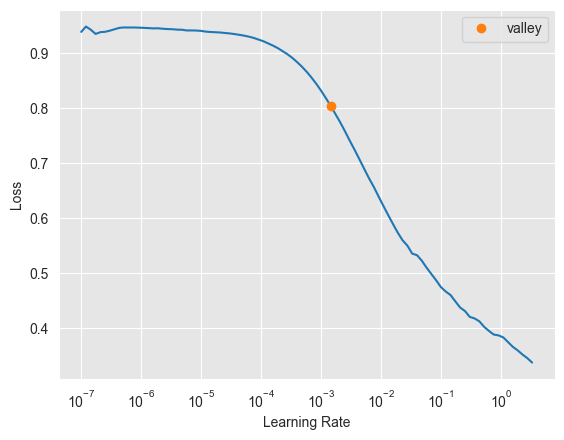

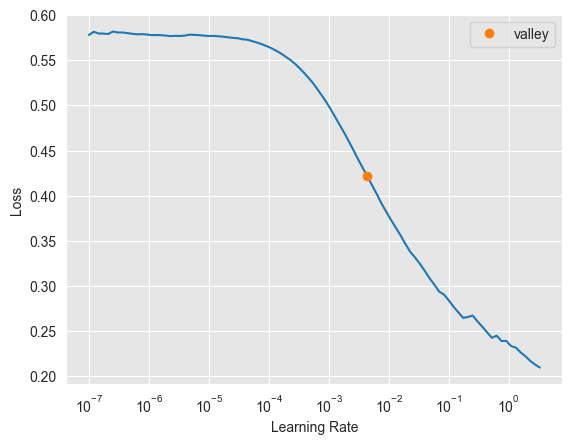

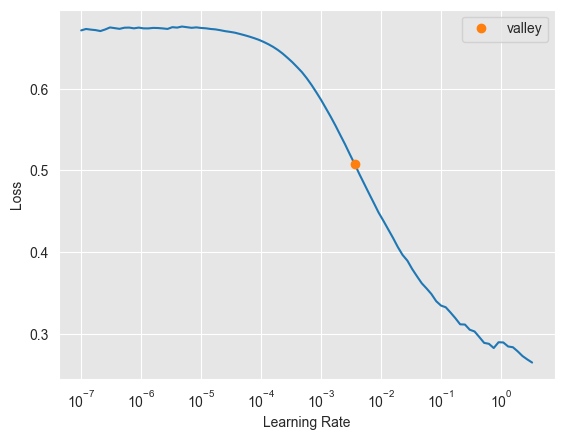

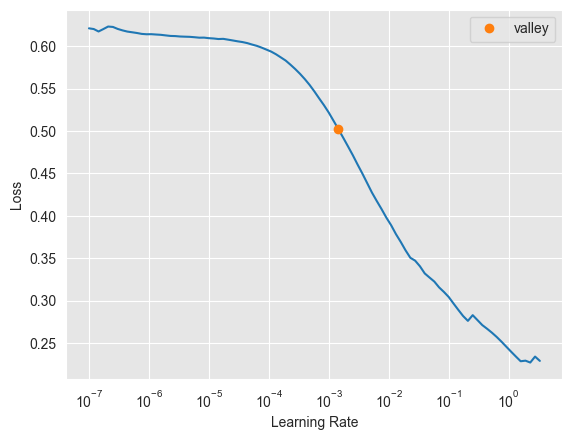

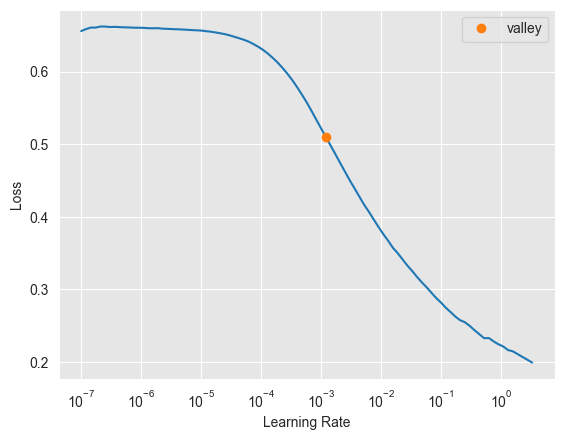

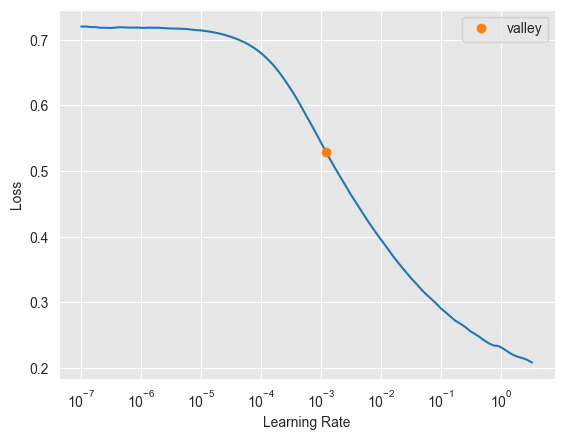

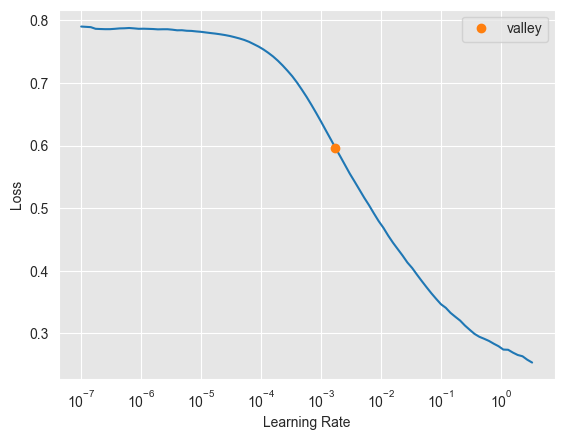

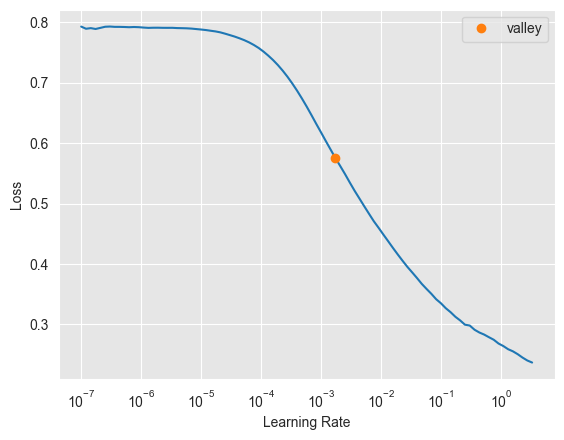

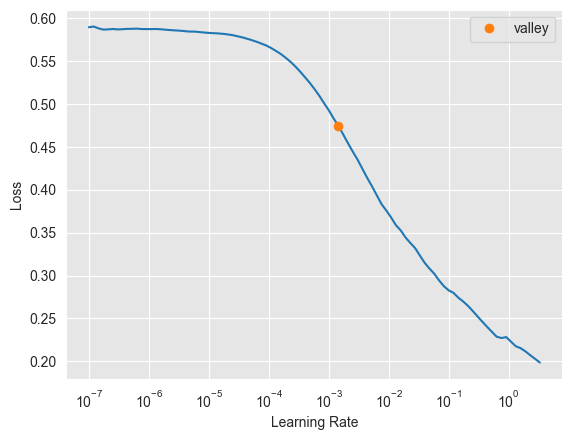

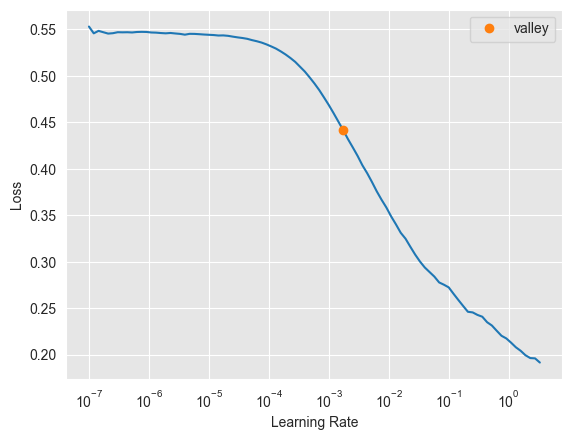

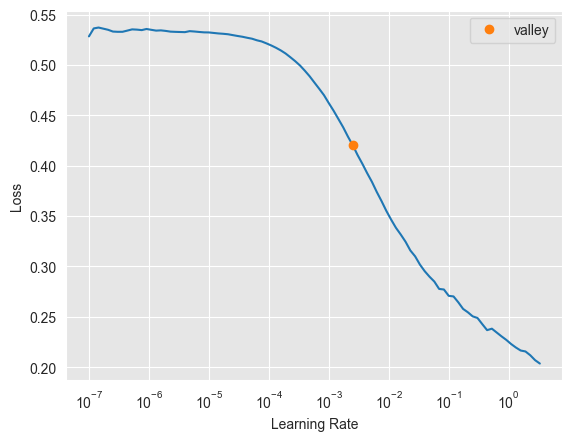

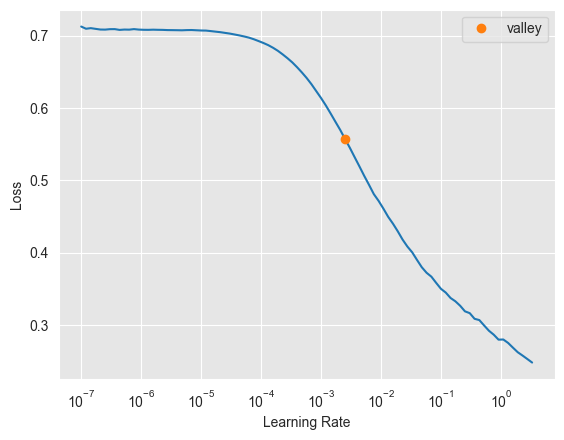

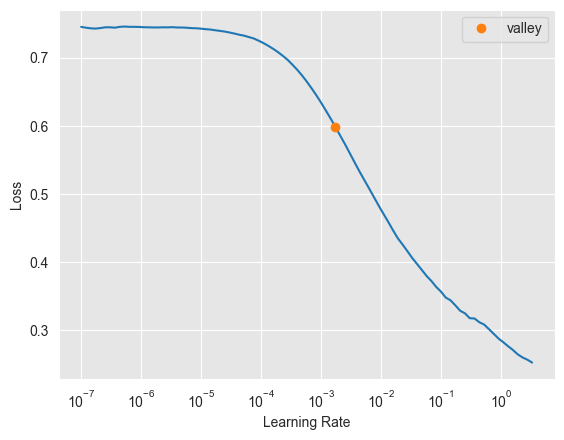

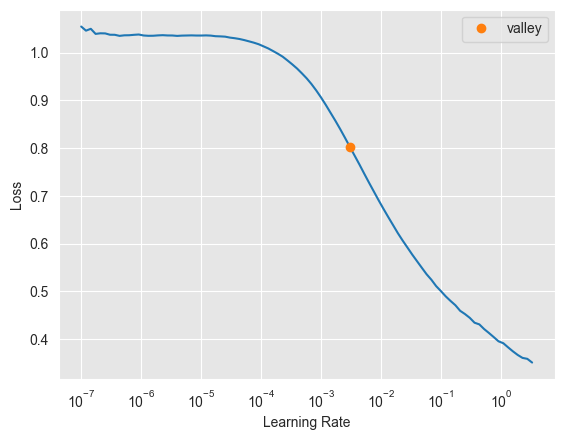

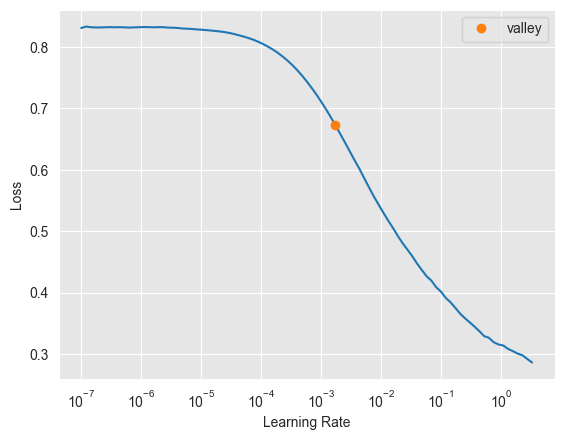

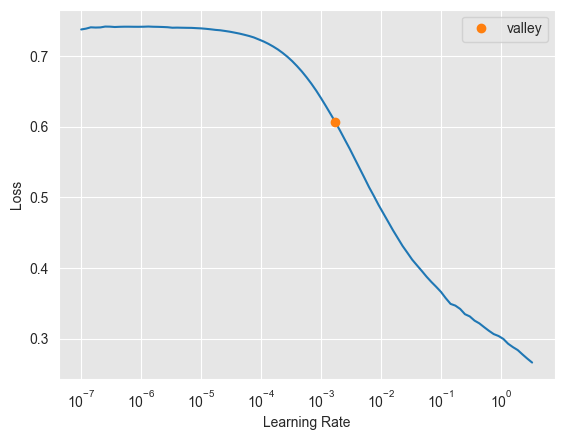

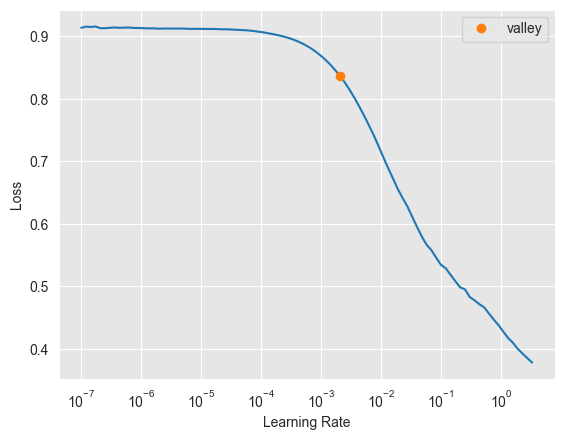

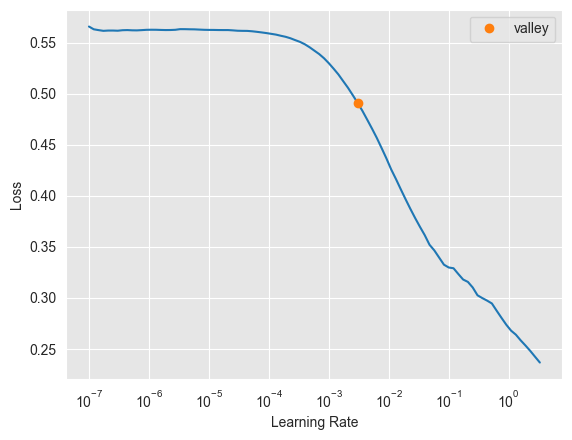

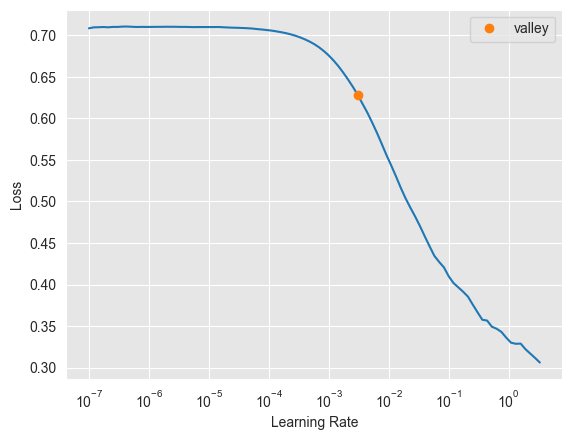

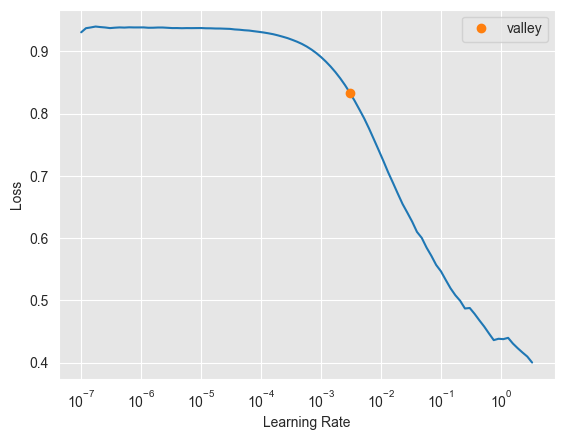

In [33]:
wandb.agent(sweep_id, train, count=60)